# Overview

This notebook contains my solutions for **<a href="https://adventofcode.com/2023" target="_blank">Advent of Code 2023</a>**.

A few notes...
- The source for this notebook source lives in my GitHub repo, <a href="https://github.com/derailed-dash/Advent-of-Code/blob/master/src/AoC_2023/Dazbo's_Advent_of_Code_2023.ipynb" target="_blank">here</a>.
- You can run this Notebook wherever you like. For example, you could...
  - Run it locally, in your own Jupyter environment.
  - Run it in a cloud-based Jupyter environment, with no setup required on your part!  For example, <a href="https://colab.research.google.com/github/derailed-dash/Advent-of-Code/blob/master/src/AoC_2023/Dazbo's_Advent_of_Code_2023.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Google Colab"/></a>
- **To run the notebook, execute the cells in the [Setup](#Setup) section, as described below. Then you can run the code for any given day.**
- Be mindful that the first time you run this notebook, you will need to **obtain your AoC session key** and store it, if you have not done so already. This allows the notebook to automatically retrieve your input data. (See the guidance in the **[Get Access to Your AoC Data](#Get-Access-to-Your-AoC-Data)** section for details.)
- Use the navigation menu on the left to jump to any particular day.
- All of my AoC solutions are documented in my <a href="https://aoc.just2good.co.uk/" target="_blank">AoC Python Walkthrough site</a>.

# Setup

You need to run all cells in this section, before running any particular day solution.

## Packages and Imports

Here we use `pip` to install the packages used by my solutions in this event.

In [1]:
%pip install jupyterlab-lsp colorama python-dotenv ipykernel ffmpeg mediapy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations
from dataclasses import asdict, dataclass, field
from typing import Optional
from enum import Enum, auto
from functools import cache, reduce
from itertools import permutations, combinations, count, cycle
from collections import Counter, deque, defaultdict
from io import BytesIO
import abc
import heapq
import copy
import operator
import logging
import time
import os
import platform
import re
import ast
import unittest
import requests
import imageio.v3 as iio
import math
import matplotlib.pyplot as plt
import mediapy as media
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from matplotlib.markers import MarkerStyle
from matplotlib import path as pltpath
import numpy as np
import networkx as nx
import pandas as pd
from tqdm.notebook import tqdm
from dotenv import load_dotenv
from pathlib import Path
from getpass import getpass
from colorama import Fore, Back, Style
from IPython.display import display
from IPython.core.display import Markdown

## Logging and Output

Set up a new logger that uses `ColouredFormatter`, such that we have coloured logging.  The log colour depends on the logging level.

In [3]:
##########################################################################
# SETUP LOGGING
#
# Create a new instance of "logger" in the client application
# Set to your preferred logging level
# And add the stream_handler from this module, if you want coloured output
##########################################################################

# logger for aoc_commons only
logger = logging.getLogger(__name__) # aoc_common.aoc_commons
logger.setLevel(logging.INFO)
stream_handler = None

class ColouredFormatter(logging.Formatter):
    """ Custom Formater which adds colour to output, based on logging level """

    level_mapping = {"DEBUG": (Fore.BLUE, "DBG"),
                     "INFO": (Fore.GREEN, "INF"),
                     "WARNING": (Fore.YELLOW, "WRN"),
                     "ERROR": (Fore.RED, "ERR"),
                     "CRITICAL": (Fore.MAGENTA, "CRT")
    }

    def __init__(self, *args, apply_colour=True, shorten_lvl=True, **kwargs) -> None:
        """ Args:
            apply_colour (bool, optional): Apply colouring to messages. Defaults to True.
            shorten_lvl (bool, optional): Shorten level names to 3 chars. Defaults to True.
        """
        super().__init__(*args, **kwargs)
        self._apply_colour = apply_colour
        self._shorten_lvl = shorten_lvl

    def format(self, record):
        if record.levelname in ColouredFormatter.level_mapping:
            new_rec = copy.copy(record)
            colour, new_level = ColouredFormatter.level_mapping[record.levelname]

            if self._shorten_lvl:
                new_rec.levelname = new_level

            if self._apply_colour:
                msg = colour + super().format(new_rec) + Fore.RESET
            else:
                msg = super().format(new_rec)

            return msg

        # If our logging message is not using one of these levels...
        return super().format(record)

if not stream_handler:
    stream_handler = logging.StreamHandler()
    stream_fmt = ColouredFormatter(fmt='%(asctime)s.%(msecs)03d:%(name)s - %(levelname)s: %(message)s',
                                   datefmt='%H:%M:%S')
    stream_handler.setFormatter(stream_fmt)
    
if not logger.handlers:
    # Add our ColouredFormatter as the default console logging
    logger.addHandler(stream_handler)

def retrieve_console_logger(script_name):
    """ Create and return a new logger, named after the script
    So, in your calling code, add a line like this:
    logger = ac.retrieve_console_logger(locations.script_name)
    """
    a_logger = logging.getLogger(script_name)
    a_logger.addHandler(stream_handler)
    a_logger.propagate = False
    return a_logger

def setup_file_logging(a_logger: logging.Logger, folder: str|Path=""):
    """ Add a FileHandler to the specified logger. File name is based on the logger name.
    In calling code, we can add a line like this:
    td.setup_file_logging(logger, locations.output_dir)

    Args:
        a_logger (Logger): The existing logger
        folder (str): Where the log file will be created. Will be created if it doesn't exist
    """
    Path(folder).mkdir(parents=True, exist_ok=True)     # Create directory if it does not exist
    file_handler = logging.FileHandler(Path(folder, a_logger.name + ".log"), mode='w')
    file_fmt = logging.Formatter(fmt="%(asctime)s.%(msecs)03d:%(name)s:%(levelname)8s: %(message)s",
                                datefmt='%H:%M:%S')
    file_handler.setFormatter(file_fmt)
    a_logger.addHandler(file_handler)
    
def top_and_tail(data, block_size=5, include_line_numbers=True, zero_indexed=False):
    """ Print a summary of a large amount of data 

    Args:
        data (_type_): The data to present in summary form.
        block_size (int, optional): How many rows to include in the top, and in the tail.
        include_line_numbers (bool, optional): Prefix with line number. Defaults to True.
        zero_indexed (bool, optional): Lines start at 0? Defaults to False.
    """
    if isinstance(data, list):
        # Get the number of digits of the last item for proper alignment
        num_digits_last_item = len(str(len(data)))

        # Format the string with line number
        def format_with_line_number(idx, line):
            start = 0 if zero_indexed else 1
            if include_line_numbers:
                return f"{idx + start:>{num_digits_last_item}}: {line}"
            else:
                return line

        start = 0 if zero_indexed else 1
        if len(data) < 11:
            return "\n".join(format_with_line_number(i, line) for i, line in enumerate(data))
        else:
            top = [format_with_line_number(i, line) for i, line in enumerate(data[:block_size])]
            tail = [format_with_line_number(i, line) for i, line in enumerate(data[-block_size:], start=len(data)-block_size)]
            return "\n".join(top + ["..."] + tail)
    else:
        return data

## Install ffmpeg

This is installed in order to render video output, i.e. for visualisations.

In [4]:
def install_ffmpeg():
    os_name = platform.system()
    
    if os_name == "Windows":
        logger.info("Installing FFmpeg on Windows...")
        os.system("winget install ffmpeg")
    elif os_name == "Linux":
        logger.info("Installing FFmpeg on Linux...")
        os.system("apt-get -qq update && apt-get -qq -y install ffmpeg")
    elif os_name == "Darwin":
        logger.info("Installing FFmpeg on macOS...")
        os.system("brew install ffmpeg")
    else:
        logger.error(f"Unsupported operating system: {os_name}")

install_ffmpeg()

logger.info("Note that the ffmpeg command may not be immediately available after first installing ffmpeg.\n" \
            "It may be necessary to relaunch the notebook environment.")
!ffmpeg -version

18:11:47.942:__main__ - INF: Installing FFmpeg on Windows...
18:11:53.134:__main__ - INF: Note that the ffmpeg command may not be immediately available after first installing ffmpeg.
It may be necessary to relaunch the notebook environment.


ffmpeg version 6.1-full_build-www.gyan.dev Copyright (c) 2000-2023 the FFmpeg developers
built with gcc 12.2.0 (Rev10, Built by MSYS2 project)
configuration: --enable-gpl --enable-version3 --enable-static --pkg-config=pkgconf --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libuavs3d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxvid --enable-libaom --enable-libjxl --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-liblensfun --enable-

## Get Access to Your AoC Data

Now provide your unique AoC session key, in order to download your input data. You can get this by:
1. Logging into [Advent of Code](https://adventofcode.com/).
1. From your browser, open Developer Tools. (In Chrome, you can do this by pressing F12.)
1. Open the `Application` tab.
1. Storage -> Cookies -> https://adventofcode.com
1. Copy the value associated with the cookie called `session`.
1. Once you've determiend your session key, I recommend you store it in a file called `.env`, in your `Advent-of-Code` folder, like this: \
`AOC_SESSION_COOKIE=536...your-own-session-key...658` \
This notebook will try to retrieve the key from that location.  If it is unable to retrieve the key, it will prompt you to enter your key in the cell below.

![Finding the session cookie](https://aoc.just2good.co.uk/assets/images/aoc-cookie.png)



In [5]:
def get_envs_from_file() -> bool:
    """ Look for .env files, read variables from it, and store as environment variables """
    potential_path = ".env"
    for _ in range(3):
        logger.debug("Trying .env at %s", os.path.realpath(potential_path))
        if os.path.exists(potential_path):
            logger.info("Using .env at %s", os.path.realpath(potential_path))
            load_dotenv(potential_path, override=True, verbose=True)
            return True
        
        potential_path = os.path.join('..', potential_path)
   
    logger.warning("No .env file found.")
    return False

get_envs_from_file() # read env variables from a .env file, if we can find one

if os.getenv('AOC_SESSION_COOKIE'):
    logger.info('Session cookie retrieved: %s...%s', os.environ['AOC_SESSION_COOKIE'][0:6], os.environ['AOC_SESSION_COOKIE'][-6:])
else: # it's not in our environment variables, so we'll need to input the value
    os.environ['AOC_SESSION_COOKIE'] = getpass('Enter AoC session key: ')

18:11:55.295:__main__ - INF: Using .env at F:\Users\Darren\localdev\Python\Advent-of-Code\.env
18:11:55.297:__main__ - INF: Session cookie retrieved: 53616c...a18261


## Load Helpers and Useful Classes

Now we load a bunch of helper functions and classes.

### Locations

Where any input and output files get stored.

<img src="https://aoc.just2good.co.uk/assets/images/notebook-content-screenshot.png" width="320" />


In [6]:
#################################################################
# Paths and Locations
#################################################################

@dataclass
class Locations:
    """ Dataclass for storing various location properties """
    script_name: str
    script_dir: Path
    input_dir: Path
    output_dir: Path
    input_file: Path

def get_locations(script_name, folder="") -> Locations:
    """ Set various paths, based on the location of the calling script. """
    current_directory = os.getcwd()
    script_dir = Path(Path().resolve(), folder, script_name)
    input_dir = Path(script_dir, "input")
    output_dir = Path(script_dir, "output")
    input_file = Path(input_dir, "input.txt")

    return Locations(script_name, script_dir,
                     input_dir,
                     output_dir,
                     input_file)

### Retrieve the Input Data

This works by using your unique session cookie to retrieve your input data. E.g. from a URL like:

`https://adventofcode.com/2015/day/1/input`

In [7]:
##################################################################
# Retrieving input data
##################################################################

def write_puzzle_input_file(year: int, day, locations: Locations):
    """ Use session key to obtain user's unique data for this year and day.
    Only retrieve if the input file does not already exist.
    Return True if successful.
    Requires env: AOC_SESSION_COOKIE, which can be set from the .env.
    """
    if os.path.exists(locations.input_file):
        logger.debug("%s already exists", os.path.basename(locations.input_file))
        return os.path.basename(locations.input_file)

    session_cookie = os.getenv('AOC_SESSION_COOKIE')
    if not session_cookie:
        raise ValueError("Could not retrieve session cookie.")

    logger.info('Session cookie retrieved: %s...%s', session_cookie[0:6], session_cookie[-6:])

    # Create input folder, if it doesn't exist
    if not locations.input_dir.exists():
        locations.input_dir.mkdir(parents=True, exist_ok=True)

    url = f"https://adventofcode.com/{year}/day/{day}/input"
    
    # Don't think we need to set a user-agent
    # headers = {
    #     "User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'
    # }
    cookies = { 
        "session": session_cookie
    }
    response = requests.get(url, cookies=cookies, timeout=5)

    data = ""
    if response.status_code == 200:
        data = response.text

        with open(locations.input_file, 'w') as file:
            logger.debug("Writing input file %s", os.path.basename(locations.input_file))
            file.write(data)
            return data
    else:
        raise ValueError(f"Unable to retrieve input data.\n" +
                         f"HTTP response: {response.status_code}\n" +
                         f"{response.reason}: {response.content.decode('utf-8').strip()}")


### Testing

A really simple function for testing that our solution produces the expected test output.

In [8]:
def validate(test, answer):
    """
    Args:
        test: the answer given by our solution
        answer: the expected answer, e.g. from instructions
    """
    if test != answer:
        raise AssertionError(f"{test} != {answer}")

### Useful Helper Classes

In [9]:
#################################################################
# POINTS, VECTORS AND GRIDS
#################################################################

@dataclass(frozen=True)
class Point:
    """ Class for storing a point x,y coordinate """
    x: int
    y: int

    def __add__(self, other: Point):
        return Point(self.x + other.x, self.y + other.y)

    def __mul__(self, other: Point):
        """ (x, y) * (a, b) = (xa, yb) """
        return Point(self.x * other.x, self.y * other.y)

    def __sub__(self, other: Point):
        return self + Point(-other.x, -other.y)

    def __lt__(self, other):
        # Arbitrary comparison logic
        return (self.x, self.y) < (other.x, other.y)
    
    def yield_neighbours(self, include_diagonals=True, include_self=False):
        """ Generator to yield neighbouring Points """

        deltas: list
        if not include_diagonals:
            deltas = [vector.value for vector in Vectors if abs(vector.value[0]) != abs(vector.value[1])]
        else:
            deltas = [vector.value for vector in Vectors]

        if include_self:
            deltas.append((0, 0))

        for delta in deltas:
            yield Point(self.x + delta[0], self.y + delta[1])

    def neighbours(self, include_diagonals=True, include_self=False) -> list[Point]:
        """ Return all the neighbours, with specified constraints.
        They are returned clockwise, starting with N.
        It wraps the generator with a list. """
        return list(self.yield_neighbours(include_diagonals, include_self))

    def get_specific_neighbours(self, directions: list[Vectors]) -> list[Point]:
        """ Get neighbours, given a specific list of allowed locations. """
        return [(self + Point(*vector.value)) for vector in list(directions)]

    @staticmethod
    def manhattan_distance(a_point: Point) -> int:
        """ Return the Manhattan distance value of this vector """
        return sum(abs(coord) for coord in asdict(a_point).values())

    def manhattan_distance_from(self, other: Point) -> int:
        """ Manhattan distance between this Vector and another Vector """
        diff = self-other
        return Point.manhattan_distance(diff)

    def __repr__(self):
        return f"P({self.x},{self.y})"

class Vectors(Enum):
    """ Enumeration of 8 directions.
    Note: y axis increments in the North direction, i.e. N = (0, 1) """
    N = (0, -1)
    NE = (1, -1)
    E = (1, 0)
    SE = (1, 1)
    S = (0, 1)
    SW = (-1, 1)
    W = (-1, 0)
    NW = (-1, -1)

class VectorDicts():
    """ Contains constants for Vectors """
    ARROWS = {
        '^': Vectors.N.value,
        '>': Vectors.E.value,
        'v': Vectors.S.value,
        '<': Vectors.W.value
    }

    DIRS = {
        'U': Vectors.N.value,
        'R': Vectors.E.value,
        'D': Vectors.S.value,
        'L': Vectors.W.value
    }

    NINE_BOX: dict[str, tuple[int, int]] = {
        # x, y vector for adjacent locations
        'tr': (1, 1),
        'mr': (1, 0),
        'br': (1, -1),
        'bm': (0, -1),
        'bl': (-1, -1),
        'ml': (-1, 0),
        'tl': (-1, 1),
        'tm': (0, 1)
    }

class Grid():
    """ 2D grid of point values. """
    def __init__(self, grid_array: list, animating: bool=False) -> None:
        self.array = grid_array
        self._width = len(self.array[0])
        self._height = len(self.array)
        
        self.animating = animating
        if self.animating:
            self._plot_info = self._setup_fig()
            self._frame_index = 0
    
    def _setup_fig(self):
        my_dpi = 120
        fig, axes = plt.subplots(figsize=(1024/my_dpi, 768/my_dpi), dpi=my_dpi, facecolor="black") # set size in pixels

        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        axes.set_aspect('equal') # set x and y to equal aspect
        axes.set_facecolor('xkcd:orange')
        
        min_x, max_x = -0.5, self.width - 0.5
        min_y, max_y = -0.5, self.height - 0.5
        axes.set_xlim(min_x, max_x)
        axes.set_ylim(max_y, min_y)

        # dynamically compute the marker size
        fig.canvas.draw()
        mkr_size = ((axes.get_window_extent().width / (max_x-min_x) * (45/fig.dpi)) ** 2)
        
        return fig, axes, mkr_size

    def animate_step(self, i):
        """ Update the plot for the ith step in the animation.
        Abstract implementation: add your logic when extending this class. """
        
        # if self._frame_index < len(self.some_updating_attribute):
        #     self._render_plot()
        #     self._frame_index += 1
        return []
    
    def create_animation(self, output_path='animation.mp4', fps=10):
        """ Abstract implementation: add your logic when extending this class.
        Creates the animation, by calling the animate_step() method to generate frames. """
        
        self._plot_info = self._setup_fig()  # Set up the figure for plotting
        fig, axes, mkr_size = self._plot_info
        
        # # Creating the animation
        # anim = FuncAnimation(fig, self.animate_step, frames=len(self.some_updating_attribute), 
        #                      interval=1000/fps, blit=True)

        # # Save the animation
        # anim.save(output_path, writer='ffmpeg')
    
    def _render_plot(self):
        """ Abstract implementation: add your rendering logic when extending this class. """
        fig, axes, mkr_size = self._plot_info
        axes.clear() # clear for each frame
        
        # plot stuff - IT SHOULD DRAW WHATEVER IS RELEVANT FOR A GIVEN FRAME
        # E.g.
        # Only plot the path up to the current frame index
        # for point, dirn in self.path_taken[:self._frame_index + 1]:
    
    def value_at_point(self, point: Point):
        """ The value at this point """
        return self.array[point.y][point.x]

    def set_value_at_point(self, point: Point, value):
        if isinstance(self.array[0], str):
            row = self.array[point.y]
            self.array[point.y] = row[:point.x] + value + row[point.x + 1:]
        else: # assume we have a replaceable type, like list[int]
            self.array[point.y][point.x] = value

    def valid_location(self, point: Point) -> bool:
        """ Check if a location is within the grid """
        if (0 <= point.x < self._width and  0 <= point.y < self._height):
            return True

        return False

    @property
    def width(self):
        """ Array width (cols) """
        return self._width

    @property
    def height(self):
        """ Array height (rows) """
        return self._height

    def all_points(self) -> list[Point]:
        points = [Point(x, y) for x in range(self.width) for y in range(self.height)]
        return points

    def rows_as_str(self):
        """ Return the grid """
        return ["".join(str(char) for char in row) for row in self.array]

    def cols_as_str(self):
        """ Render columns as str. Returns: list of str """
        cols_list = list(zip(*self.array))
        return ["".join(str(char) for char in col) for col in cols_list]

    def transpose(self) -> Grid:
        return Grid(list(zip(*self.array)))
    
    def flip_vertical(self) -> Grid:
        """ Flip the array about the vertical axis of symmetry """
        return Grid([row[::-1] for row in self.array])
    
    def flip_horizontal(self) -> Grid:
        """ Flip the array about the horizontal axis of symmetry """
        return Grid(self.array[::-1])
    
    def rotate_90(self, ccw=False) -> Grid:
        """ Rotates 90 degrees CW. It works by transposing, then flipping. """
        if ccw:
            flipped = self.flip_vertical()
        else:
            flipped = self.flip_horizontal()
    
        return flipped.transpose()
    
    def __repr__(self) -> str:
        return f"Grid(size={self.width}*{self.height})"

    def __str__(self) -> str:
        return "\n".join("".join(map(str, row)) for row in self.array)
    

### Useful Helper Functions

In [10]:
#################################################################
# CONSOLE STUFF
#################################################################

def cls():
    """ Clear console """
    os.system('cls' if os.name=='nt' else 'clear')

#################################################################
# USEFUL FUNCTIONS
#################################################################

def binary_search(target, low:int, high:int, func, *func_args, reverse_search=False):
    """ Generic binary search function that takes a target to find,
    low and high values to start with, and a function to run, plus its args.
    Implicitly returns None if the search is exceeded. """

    res = None  # just set it to something that isn't the target
    candidate = 0  # initialise; we'll set it to the mid point in a second

    while low < high:  # search exceeded
        candidate = int((low+high) // 2)  # pick mid-point of our low and high
        res = func(candidate, *func_args) # run our function, whatever it is
        logger.debug("%d -> %d", candidate, res)
        if res == target:
            return candidate  # solution found

        comp = operator.lt if not reverse_search else operator.gt
        if comp(res, target):
            low = candidate
        else:
            high = candidate

def merge_intervals(intervals: list[list]) -> list[list]:
    """ Takes intervals in the form [[a, b][c, d][d, e]...]
    Intervals can overlap.  Compresses to minimum number of non-overlapping intervals. """
    intervals.sort()
    stack = []
    stack.append(intervals[0])

    for interval in intervals[1:]:
        # Check for overlapping interval
        if stack[-1][0] <= interval[0] <= stack[-1][-1]:
            stack[-1][-1] = max(stack[-1][-1], interval[-1])
        else:
            stack.append(interval)

    return stack

@cache
def get_factors(num: int) -> set[int]:
    """ Gets the factors for a given number. Returns a set[int] of factors.
        # E.g. when num=8, factors will be 1, 2, 4, 8 """
    factors = set()

    # Iterate from 1 to sqrt of 8,
    # since a larger factor of num must be a multiple of a smaller factor already checked
    for i in range(1, int(num**0.5) + 1):  # e.g. with num=8, this is range(1, 3)
        if num % i == 0: # if it is a factor, then dividing num by it will yield no remainder
            factors.add(i)  # e.g. 1, 2
            factors.add(num//i)  # i.e. 8//1 = 8, 8//2 = 4

    return factors

def to_base_n(number: int, base: int):
    """ Convert any integer number into a base-n string representation of that number.
    E.g. to_base_n(38, 5) = 123

    Args:
        number (int): The number to convert
        base (int): The base to apply

    Returns:
        [str]: The string representation of the number
    """
    ret_str = ""
    curr_num = number
    while curr_num:
        ret_str = str(curr_num % base) + ret_str
        curr_num //= base

    return ret_str if number > 0 else "0"


### Generic Initialisation


In [11]:
FOLDER = "aoc"
YEAR = 2023
logger_identifier = "aoc" + str(YEAR)
logger = retrieve_console_logger(logger_identifier)
logger.setLevel(logging.DEBUG)

# Days

Here you'll find a template to build a solution for a given day, and then the solutions for all days in this event.

To copy the template day, select all the cells in the `Day n` template, add a new cell at the end, and then paste the cells there.

---
## Day 1: Trebuchet?!

In [ ]:
DAY = 1
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 1 Part 1

And we're off!!  Welcome to the first day of Advent of Code 2023!!

Today was a troublesome start for me.  My Internet was out.  (Thanks, Virgin Media.) So, after unsuccessful restarts of the router and home network, I switched over to mobile hotspot.

Part 1 is pretty trivial, as we've come to expect. You need to identify the first and last digits of each line of a string. Concatenating these two values gives you a two digit number, which the puzzle calls a _calibration value_. Then we just add them all together.

**My Solution**

- For each line, I simply loop through each char in the line, and use the `isdigit()` method to determine if it is a digit.
- Then repeat, but this time, looping from the end using the Python construct `[::-1]` which just means: start from the end, and then step with increments of `-1`. I.e. move backwards.
- Finally, concatenate the two digits (still as strings), to update a two digit number. Then convert it to an int.
- Store all these ints in a list.  And at the end, return the sum of the list.

In [ ]:
num_words = {"one": 1,
             "two": 2,
             "three": 3,
             "four": 4,
             "five": 5,
             "six": 6,
             "seven": 7,
             "eight": 8,
             "nine": 9
             }

In [ ]:
def solve(data: list[str], with_spelled_nums=False):
    calibration_vals = []
    for line in data:
        logger.debug(line)
        
        first_posn = 1e6        
        last_posn = -1
        first = last = ""

        for posn, char in enumerate(line): # read from start
            if char.isdigit():
                first_posn = posn
                first = char
                break
            
        for posn, char in enumerate(line[::-1]): # read from the end
            if char.isdigit():
                last_posn = len(line) - posn - 1 # remember, we're now counting from the end!!
                last = char
                break

        if with_spelled_nums:
            for num_word in num_words:
                posn = line.find(num_word)
                if 0 <= posn < first_posn:
                    first_posn = posn
                    first = str(num_words[num_word]) # map it back to int
            
                posn = line.rfind(num_word)
                if posn > last_posn:
                    last_posn = posn
                    last = str(num_words[num_word]) # map to the int
        
        calibration_vals.append(int(first + last))
    
    return sum(calibration_vals)  
        

In [ ]:
%%time
sample_inputs = [["1abc2", "pqr3stu8vwx", "a1b2c3d4e5f", "treb7uchetabcdef"]]
sample_answers = [142]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input), curr_ans) # test with sample data

soln = solve(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 1 Part 2

For Day 1, this wasn't quite as trivial as I was expecting! Now we have to also find the positions of any "spelled" versions of the digits 0-9.

**My solution:**

- Create a `dict` to store the spelled versions of 1-9, and map them to their respective int values.
- Now, with each line, perform the same code as we did for Part 1 to find the first and last positions of the digit representation. 
  - But this time, store the positions found, as well as the values. I use the [`enumerate()`](https://aoc.just2good.co.uk/python/enumerate) to give me the current position of each char in my line.
  - Be really careful when storing the position when counting from the end.  This tripped me up for a couple of minutes!!  When we're looping through chars from the end, backwards, we want to store the position in the string, not the current enumeration value. 
- Then, run another loop that looks for each spelled number in our dict of spelled numbers.
  - To search for our current spelled number in our line from the start, using the `find()` method.
  - To search for our current spelled number in our line from the end, using the `rfind()` method.
  - Whenever we find a spelled number, check whether we found it at a position that is earlier / later (as required) than the digit we found before.
  - Whenever I find such a spelled number, I convert the int value in the dict to a string, so that I can concatenate the string values, just as we did before.

In [ ]:
%%time
sample_inputs = [["two1nine", 
                  "eightwothree", 
                  "abcone2threexyz", 
                  "xtwone3four", 
                  "4nineeightseven2", 
                  "zoneight234", 
                  "7pqrstsixteen"]]
sample_answers = [281]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input, with_spelled_nums=True), curr_ans) # test with sample data

soln = solve(input_data, with_spelled_nums=True)
logger.info(f"Part 2 soln={soln}")

---
## Day 2: Cube Conundrum

In [ ]:
DAY = "2" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 2 Part 1

In each game, we have a bag containing some number of red, green and blue cubes.  The bag is sampled several times per game. Our input data shows these random samples for each game. E.g.

```
Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green
Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue
Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red
Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red
Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green
```

**Determine which games would have been possible if the bag had been loaded with only 12 red cubes, 13 green cubes, and 14 blue cubes. What is the sum of the IDs of those games?**

**My solution:**

- I create a CubeSample [class](https://aoc.just2good.co.uk/python/classes) to store each sample, i.e. the number of r, g, b cubes.
- I create a Game class to store the game ID and all the samples for that game.
- I parse the input with [regex](https://aoc.just2good.co.uk/python/regex). My approach was:
  - Split the game line into the game part, and the samples part. Retrieving the game ID is trivial.
  - For the samples, use a regex that looks for "n colour", and use a regex `finditer()` to find all matches for this.
  - Create a [defaultdict](https://aoc.just2good.co.uk/python/defaultdict) that sets the initial values for r, g, b to 0.
  - Then iterate over the matches from `finditer()``, and update the r, g, b as required.
- Now I simply loop through each game. 
  - For each game, I loop through the samples. If any sample has more r, g, b than we're allowed, then this game is impossible.
  - Build up a list of the games that are possible. Then sum up the IDs with a [comprehension](https://aoc.just2good.co.uk/python/comprehensions).

In [ ]:
@dataclass
class CubeSample:
    """ A sample contains a number of red, blue, and green cubes """
    red: int=0
    blue: int=0
    green: int=0

@dataclass
class Game:
    """ A game has an ID, and a random number of samples """
    id: int
    samples: list[CubeSample]

def parse_input(data) -> list[Game]:
    game_pattern = re.compile(r"Game\s+(\d+)")
    cubes_pattern = re.compile(r"(\d+)\s*(\w+)") # E.g. "3 blue" 
    
    games = []
    for line in data:
        game_part, samples_part = line.split(":")
        game_id = int(game_pattern.findall(game_part)[0])
        samples = samples_part.split(";")
        
        cube_samples = []
        for sample in samples:
            matches = cubes_pattern.finditer(sample)
            cube_counts = {"red": 0, "green": 0, "blue": 0} # reset cube counts for each sample
            for match in matches:
                cube_count, cube_colour = match.groups()
                cube_counts[cube_colour] = int(cube_count)
            
            cube_samples.append(CubeSample(cube_counts["red"], cube_counts["blue"], cube_counts["green"]))
        
        games.append(Game(game_id, cube_samples))
        
    return games
      
def solve(games: list[Game]):
    """ Return the sum of the IDs for games that are possible. """
    
    allowed_red = 12
    allowed_green = 13
    allowed_blue = 14
    
    possible_games = []
    for game in games:
        possible = True
        for game_sample in game.samples:
            if (game_sample.red > allowed_red
                    or game_sample.green > allowed_green
                    or game_sample.blue > allowed_blue):
                possible = False
            
        if possible:
            possible_games.append(game)
            
    return sum(game.id for game in possible_games)

In [ ]:
%%time
sample_inputs = [["Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green",
                  "Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue",
                  "Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red",
                  "Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red",
                  "Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green"]
                ]
sample_answers = [8]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    sample_games = parse_input(curr_input)
    validate(solve(sample_games), curr_ans) # test with sample data

games = parse_input(input_data)
soln = solve(games)
logger.info(f"Part 1 soln={soln}")

### Day 2 Part 2

**For each game, find the minimum set of cubes that must have been present. What is the sum of the power of these sets?**

Here, we need to look at all the samples for a given game, and determine the largest number of cubes shown of each colour, across the samples.

**My solution:**

Fortunately, since we already have our list of Games, this is now trivial to do. Simply iterate through the games, and for each game, iterate over all the samples. For each sample, determine if the number of any of r, g, b is greater than the biggest number of which we've found so far.

Then, multiply the r, g, b to get the `power` of the game. Then sum up all the powers.

In [ ]:
def solve_part2(games: list[Game]):
    """ Return the sum of the powers of all the games """
    game_powers = []
    for game in games:
        max_blue = max_green = max_red = 0
        for game_sample in game.samples:
            max_blue = max(max_blue, game_sample.blue)
            max_green = max(max_green, game_sample.green)
            max_red = max(max_red, game_sample.red)
     
        # We're told that power = product of r, g, b   
        game_powers.append(max_blue*max_green*max_red)
    
    return sum(game_powers)    

In [ ]:
%%time
sample_inputs = [["Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green",
                  "Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue",
                  "Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red",
                  "Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red",
                  "Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green"]
                ]
sample_answers = [2286]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    sample_games = parse_input(curr_input)
    validate(solve_part2(sample_games), curr_ans) # test with sample data

soln = solve_part2(games)
logger.info(f"Part 2 soln={soln}")

---
## Day 3: Gear Ratios

In [ ]:
DAY = "3" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 3 Part 1

I'm finding AoC fairly tough this year. I wasn't expecting the early challenges to be this tricky.

Anyhoo...

We're given a 2D grid, called the _engine schematic_. That grid contains numbers, periods (which should be ignored), and symbols (anything else). We need to determine the _part numbers_, which we are told are any numbers adjacent to a symbol.

It looks like this:

```text
467..114..
...*......
..35..633.
......#...
617*......
.....+.58.
..592.....
......755.
...$.*....
.664.598..
```

**What is the sum of all of the part numbers in the engine schematic?**

**My solution:**

- I get to reuse one of my [helper classes](https://aoc.just2good.co.uk/python/reusable_code).  Yay!  
  - I'm going to reuse my `Point` class, which stores x, y coordinates, but also has the ability to return all of its adjacent neighbours.
  - I'm going to reuse my `Grid` class, which already knows how to create a 2D grid, iterate through the points in the grid, get the values at any location, and determine if a specied point is in the grid.
- I create a new [class](https://aoc.just2good.co.uk/python/classes) called `EngineGrid` by extending `Grid`.
  - This class knows how to return all the points that are symbols.
- To solve:
  - First, get all the symbol locations. This is trivial.
  - Get the value of this symbol, and store it alongside the location in a dictionary.
  - Then, get all the neighbour locations for each symbol location.
  - Check if this neighbour is part of a part number range we've already found.  If it is, then we don't need to check this neighbour; we already know it's part of a part number.
  - If the neighbour is a valid location, check if it is a digit. If it is, then this location is _in_ a part number. If so, use the method `get_part_number_continugous_range()` to determine the full set of points that make up this part number. It works by taking this location on this line of the grid, and walking backwards and fowards, until the value found is no longer a digit. We return the full set of contiguous digits as a part number range.
  - Add this to the [set](https://aoc.just2good.co.uk/python/sets) of ranges for this symbol, i.e. in the `ranges_for_symbol` dict. Note, here I'm using a [defaultdict](https://aoc.just2good.co.uk/python/defaultdict), such that I can initialise each entry with an empty `set`, and then add to the set whenever we find a range.
  - Also, add all the points from this range to a `set` called `all_range_locations_for_symbol`. We use this when checking each neighbour, to see if this neighbour is already part of a range associated with this symbol.
  - Also, determine the part number for this range, using our `get_part_number_for_range()` method. Store the result in a `dict` called `part_range_to_num`, where the key is the range `tuple` itself.
  - Finally, we can sum up all the part number values, by summing the values from the `dict` of `part_range_to_num`.

### Day 3 Part 2

Now we're told we need to find symbols that are _gears_, i.e. the symbols that are simply `*`. And we need to find all the gears that have exactly two adjacent part numbers. Where this is true, the product of the two part numbers is the _gear ratio_. Then we need to add up all the gear ratios.

**What is the sum of all of the gear ratios in your engine schematic?**

**My solution:**

This is a fairly trivial addition. We already have the `ranges_for_symbol` dictionary. So, in our loop that processes each symbol, we now:

- Check if the symbol is a gear, i.e. `*`
- If so, check how many ranges are associated with this symbol.
- If there are exactly two ranges, then we need to determine the part number values of this ranges, and multiply them together to obtain our `gear_ratio` for this gear.
- Finally, add up all the gear ratios.



In [ ]:
class EngineGrid(Grid):
    def get_symbol_locations(self) -> list[Point]:
        """ Return all locations that contain a symbol """
        symbol_locations = [point for point in self.all_points() if self._is_symbol(point)]
        return symbol_locations
    
    def _is_symbol(self, point: Point) -> bool:
        """ A symbol is anything that is not numeric, or not a period. """
        val = str(self.value_at_point(point))
        if val.isdigit():
            return False
        
        if val == ".":
            return False
        
        return True
    
    def get_part_number_contiguous_range(self, point: Point) -> tuple[Point, ...]:
        """ Given a point within a part number, we want to return the entire range or points that make up that part number. """
        line = self.array[point.y] # get the row this point is on
    
        # Find the start of the contiguous digits
        start = point.x
        while start > 0 and line[start - 1].isdigit():
            start -= 1

        # Find the end of the contiguous digits
        end = point.x
        while end < len(line) - 1 and line[end + 1].isdigit():
            end += 1

        # Return the contiguous locations that make up a part number
        contiguous_locations = [Point(x, point.y) for x in range(start, end+1)]
        return tuple(contiguous_locations)

    def get_part_number_for_range(self, part_range: tuple[Point, ...]) -> int:
        """ Given a set of points that make up a part number, return the part number they contain. """
        part_num = ""
        for point in part_range:
            part_num += self.value_at_point(point)
            
        return int(part_num)

In [ ]:
def solve(input_data) -> tuple[int, int]:
    """ Part 1: determine the sum of all part numbers, where a part number is 
                a full set of continguous digits adjacent to a symbol. 
        Part 2: determine the gear ratios, where a gear ratio is the product of the part numbers
                adjacent to a gear, for any gear that has exactly two adjacent part numbers. """
    points_and_symbols = [] # (point, value-for-point)
    part_number_ranges = set() # = all the points in a range. Use set so we don't double count ranges.
    ranges_for_symbol = defaultdict(set) # { (point, value), {ranges} }
    part_range_to_num = {} # so we can cache the part number corresponding to a range
    gear_ratios = [] # a gear ratio is given by the product of its two adjacent part numbers
    
    engine = EngineGrid(input_data)
    
    # get the locations of symbols, e.g. * ?, but not .
    symbol_locations = engine.get_symbol_locations()
    for point in symbol_locations:
        all_range_locations_for_symbol = set()
        symbol_val = engine.value_at_point(point)
        points_and_symbols.append((point, symbol_val))
        
        # get adjacent locations to this symbol
        for neighbour in point.neighbours():
            if neighbour in all_range_locations_for_symbol:
                continue    # we don't care about neighbours in ranges we've already found
            
            if engine.valid_location(neighbour): # check it is in the grid
                val = str(engine.value_at_point(neighbour))
                if val.isdigit(): # this neighbour is a point in a part number
                    range_for_locn = engine.get_part_number_contiguous_range(neighbour) # gets range as tuple
                    part_range_to_num[range_for_locn] = engine.get_part_number_for_range(range_for_locn)
                    ranges_for_symbol[(point, symbol_val)].add(range_for_locn) # add this range for this symbol
                    all_range_locations_for_symbol.update(set(range_for_locn)) # add all locations from this range
                
        if symbol_val == "*": # if this is a gear
            gear_ranges = ranges_for_symbol[(point, symbol_val)]
            if gear_ranges and len(gear_ranges) == 2: # if this gear has exactly two ranges
                gear_part_nums = [part_range_to_num[gear_range] for gear_range in gear_ranges]
                gear_ratios.append(reduce(operator.mul, gear_part_nums))
                
        part_number_ranges.update(ranges_for_symbol[(point, symbol_val)])
        
    return sum(part_range_to_num.values()), sum(gear_ratios)


In [ ]:
%%time
sample_inputs = [["467..114..",
                  "...*......",
                  "..35..633.",
                  "......#...",
                  "617*......",
                  ".....+.58.",
                  "..592.....",
                  "......755.",
                  "...$.*....",
                  ".664.598.."]]
sample_answers = [(4361, 467835)]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input), curr_ans) # test with sample data

part_num_sum, gear_ratios_sum = solve(input_data)
logger.info(f"Part 1 soln: {part_num_sum=}")
logger.info(f"Part 2 soln: {gear_ratios_sum=}")

---
## Day 4: Scratchcards

In [ ]:
DAY = "4" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 4 Part 1

We have a set of scratch cards.  Each card has an `id`, then a set of `winning` numbers, then a set of `actual` numbers that were scratched. The score of each scratch card depends on the number of winning numbers we have matched. The first match gives us 1 point, and each additional match doubles the score.

**How points are the pile of scratch cards worth, in total?**

**My solution:**

This is pretty simple.

- I create a `ScratchCard` [dataclass](https://aoc.just2good.co.uk/python/classes#dataclass) which:
  - Stores the card ID.
  - Stores the winning numbers, and the scratched numbers, both as sets.  I want to use sets because I will want to determine the intersection of these two sets, i.e. how many winning numbers were matched. [Set algebra](https://aoc.just2good.co.uk/python/sets) makes this super easy.
  - Has a `score()` method which determines the score, according to the rules.
- Then I parse the input data using [regex](https://aoc.just2good.co.uk/python/regex). Let me explain how \
  `Card(?:\s+)(\d+):\s*((?:\d+\s*)+)(?: \|\s+)((?:\d+\s*)+)` works:
  - `(\d+)`: This is a capturing group that matches one or more digits. The `\d` is a shorthand character class that matches any digit (0-9), and the `+` means one or more of the preceding element. This is how I capture the `id`.
  - `\s*`: This matches zero or more whitespace characters. The `*` means zero or more of the preceding element.
  - `((?:\d+\s*)+)`: This is a capturing group containing a non-capturing group. The non-capturing group `(?:\d+\s*)` matches one or more digits followed by zero or more whitespace characters. The outer capturing group with the `+` at the end repeats this pattern one or more times. This is how I capture ALL of the `winning` numbers.
  - `(?: \|\s+)`: This is another non-capturing group. It matches a literal space, followed by a vertical bar `|`, followed by one or more whitespace characters.
  - `((?:\d+\s*)+)`: The same as before. This is how I capture ALL of the `actual` numbers.
- I use this regex to parse each line:
  - This gives me the `id`, a string containing all the `winning` numbers, and a string containing all the `actual` numbers.
  - I split the `winning` and `actual` numbers at the space, using `split()`. This gives me a list of string values. Then I convert the string values to `int` using `map()`, and finally convert each `list` to a `set`.
  - Now I can create an instance of `ScoreCard` from the `id` and the two sets.

- Finally, just add up all the scores from each card using `sum` and a [list comprehension](https://aoc.just2good.co.uk/python/comprehensions).

In [ ]:
@dataclass
class ScratchCard:
    """ A scratchcard has an ID, winning numbers, and (actual) numbers scratched. """
    id: int
    winning: set[int]
    actual: set[int]
    
    def matches(self) -> int:
        """ Return the number of winning numbers we have matched. """
        return len(self.winning & self.actual)
    
    def score(self) -> int:
        """ For every winning number, double the score. Examples scores...
        0 matches -> 0
        1 match   -> 1
        2 matches -> 2
        3 matches -> 4, etc """
        num_matches = self.matches()
        return 2**(num_matches-1) if num_matches > 0 else 0

In [ ]:
def parse_cards(data) -> list[ScratchCard]:
    scratch_card_pattern = r"Card(?:\s+)(\d+):\s*((?:\d+\s*)+)(?: \|\s+)((?:\d+\s*)+)"
    scratch_card_matcher = re.compile(scratch_card_pattern)
    scratch_cards = []
    for line in data:
        id, winning, actual = scratch_card_matcher.findall(line)[0]
        
        id = int(id)
        winning = set(map(int, winning.split()))
        actual = set(map(int, actual.split()))
        scratch_cards.append(ScratchCard(id, winning, actual))
        
    return scratch_cards

In [ ]:
def solve_part1(cards: list[ScratchCard]):  
    return sum(card.score() for card in cards)

In [ ]:
%%time
sample_inputs = [["Card 1: 41 48 83 86 17 | 83 86  6 31 17  9 48 53",
                  "Card 2: 13 32 20 16 61 | 61 30 68 82 17 32 24 19",
                  "Card 3:  1 21 53 59 44 | 69 82 63 72 16 21 14  1",
                  "Card 4: 41 92 73 84 69 | 59 84 76 51 58  5 54 83",
                  "Card 5: 87 83 26 28 32 | 88 30 70 12 93 22 82 36",
                  "Card 6: 31 18 13 56 72 | 74 77 10 23 35 67 36 11"]
]
sample_answers = [13]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    sample_cards = parse_cards(curr_input)  
    validate(solve_part1(sample_cards), curr_ans) # test with sample data

cards = parse_cards(input_data)
soln = solve_part1(cards)
logger.info(f"Part 1 soln={soln}")

### Day 4 Part 2

Now we're told that there's no such thing as a _score_. Instead scratchcards only cause you to win more scratchcards equal to the number of winning numbers you have. You win copies of the scratchcards below the winning card equal to the number of matches.

**how many total scratchcards do you end up with?**

**My solution**

I spent several minutes thinking about how to solve this problem, before writing any code.  At first, I was thinking about some sort of `while loop` that iterates through cards, and only exits when there are no more cards. I was thinking I could insert duplicate cards into the list as I iterate.

But then I realised that I didn't need to do that.  I simply needed to keep a count of how many there are of each card ID. I can do that with a `dict`. So my strategy:

- Create a `dict` that stores the number of cards for each card ID.
- Loop through all the cards we have to initialise the dict. There will be one of each.
- Then, loop through the cards again, in order.  For each card:
  - Get the number of matches.
  - Use this number of matches to determine the successive cards that need to be duplicated.
  - Increment the count of each of those successive cards, by the count of the card we're currently on. (Because it might not be 1.)

Even though it took my tiny brain a little while to realise this approach, the actual code is pretty trivial.

The solution is fast, and only takes a couple of milliseconds.

In [ ]:
def solve_part2(cards: list[ScratchCard]):
    card_counts = {}
    for card in cards: # initialise our card counts 
        card_counts[card.id] = 1
    
    for card in cards:
        count_this_card = card_counts[card.id]
        for i in range(card.id+1, card.id+1+card.matches()):
            card_counts[i] += count_this_card
    
    logger.debug(card_counts)
    total_card_count = sum(card_counts.values())
    return total_card_count

In [ ]:
%%time
sample_inputs = [["Card 1: 41 48 83 86 17 | 83 86  6 31 17  9 48 53",
                  "Card 2: 13 32 20 16 61 | 61 30 68 82 17 32 24 19",
                  "Card 3:  1 21 53 59 44 | 69 82 63 72 16 21 14  1",
                  "Card 4: 41 92 73 84 69 | 59 84 76 51 58  5 54 83",
                  "Card 5: 87 83 26 28 32 | 88 30 70 12 93 22 82 36",
                  "Card 6: 31 18 13 56 72 | 74 77 10 23 35 67 36 11"]
]
sample_answers = [30]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    sample_cards = parse_cards(curr_input)  
    validate(solve_part2(sample_cards), curr_ans) # test with sample data

soln = solve_part2(cards)
logger.info(f"Part 2 soln={soln}")

---
## Day 5: If You Give A Seed A Fertilizer

In [ ]:
DAY = "5" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 5 Part 1

Our input includes:

- Seeds to be planted, as ints.
- Maps, in the the format: 
  - destination-range-start, source-range-start, range-length. \
    The source and destination ranges will be the same length.
- We have the following maps:
  - seed-to-soil
  - soil-to-fertilizer
  - fertilizer-to-water
  - water-to-light
  - light-to-temperature
  - temperature-to-humidity
  - humidity-to-location

E.g. 

```
soil-to-fertilizer map:
0 15 37
37 52 2
39 0 15
```

Unmapped source numbers map to the same destination number.

**What is the lowest location number that corresponds to any of the initial seed numbers?**

**My solution:**

- We need a rules engine that takes a value and determines the target value for that map.
- I've done this by creating a class called `GardinerMap`.
- Each instance of `GardinerMap` contains the source and target ranges for that map type.
- The `GardinerMap`:
  - Stores all source ranges in that map as a list of tuples, with each tuple being `(source start, range length)`.
  - Stores all destination ranges in that map as a list of tuples, with each tuple being `(destination start, range length)`.
  - All the actual mapping is done in the method `get_target()`. It iterates through each range, and determines if our input value is part of that range. If it is, we apply the required _shift_, which is the difference between the destination range start and the source range start. Now we've finished mapping, so we return the mapped value.

We need to start by passing the seed value to `get_target()` of our first `GardinerMap`. This returns a new value.  We then take this value and pass it into `get_target()` of the second `GardinerMap`.  And so on, until we've done this for every `GardinerMap`.



  - Finally, back in our `solve_part1()` method.


In [ ]:
@dataclass
class GardinerMap():
    source_type: str
    dest_type: str
    
    src_ranges: list[tuple[int,int]] = field(default_factory=list) # [(src_start, length), (src_start, length), ... ]
    dest_ranges: list[tuple[int,int]] = field(default_factory=list) # [(dest_start, length), (dest_start, length), ... ]
    
    def add_range(self, src_start: int, dest_start: int, range_length: int):
        """ Add a range which contains src start, dest start, and the length of the range """
        self.src_ranges.append((src_start, range_length)) 
        self.dest_ranges.append((dest_start, range_length))
        
    def _sort_ranges(self):
        """ Sort the range into ascending numeric, based on source range start values """
        
        # Sort src_ranges and get the order of indices
        index_order = sorted(range(len(self.src_ranges)), key=lambda i: self.src_ranges[i][0])

        # Now sort both ranges
        self.src_ranges = [self.src_ranges[i] for i in index_order]
        self.dest_ranges = [self.dest_ranges[i] for i in index_order]

    def finalise(self):
        """ Sort the range into ascending numeric, based on source range start values """
        self._sort_ranges()
        
    def get_target(self, src_val: int):
        """ Map a source value to a target value """
        target = src_val # if our source isn't in a range, then return the same value
        
        for i, curr_range in enumerate(self.src_ranges):
            src_start = curr_range[0]
            src_end = curr_range[0] + curr_range[1] # exclusive end
            if src_start <= src_val < src_end: # if our source is in a range, then apply the shift
                target = src_val - src_start + self.dest_ranges[i][0]
                break # we've mapped the value, so no more ranges need to be checked
        
        return target

    # For Part 2
    def map_intervals(self, src_intervals: list[tuple[int, int]]) -> list[tuple[int, int]]:
        """ 
        Take input ranges and return output ranges.
        - src_ranges: [(rng1_start, rng1_end), (rng2_start, rng2_end), ... ] 
        """
        new_intervals = []
        
        # Iterate through the ranges, just as we did when mapping a single seed
        for i, curr_range in enumerate(self.src_ranges): 
            src_start = curr_range[0]
            src_end = curr_range[0] + curr_range[1] # exclusive end
            dest = self.dest_ranges[i][0]

            temp_intervals = []

            while src_intervals: # process the current interval       
                (int_start, int_end) = src_intervals.pop()
                
                # Split the interval using the ranges in our map
                #### Scenario 1: ####
                # [int_start                                  int_end]
                #            [src_start      src_end]
                # [left     ][mid                   ][right          ]
                #
                #### Scenario 2: ####
                #                [int_start         int_end]
                #   [src_start     src_end]
                #   [n/a        ][mid     ][right          ]
                left = (int_start, min(int_end, src_start))
                mid = (max(int_start, src_start), min(src_end, int_end))
                right = (max(src_end, int_start), int_end)
                
                if left[1] > left[0]: # if left has +ve length, then scenario 1, else scenario 2
                    temp_intervals.append(left) # pass on the interval unchanged
                if mid[1] > mid[0]: # if mid has +ve length, then we need to apply the shift to this interval
                    # furthermore, once mapped, we know this interval wont appear in another range
                    new_intervals.append((mid[0]-src_start+dest, mid[1]-src_start+dest))
                if right[1] > right[0]:  # if right has +ve length
                    temp_intervals.append(right) # pass on the interval unchanged
            
            src_intervals = temp_intervals
                    
        return new_intervals + src_intervals

In [ ]:
def parse_data(data: list[str]) -> tuple[list[int], list[GardinerMap]]:
    """ Parse input data, and convert to:
    - seeds: list of int
    - GardinerMap instances: list of GardinerMap """
    
    seeds = []
    source_maps = [] # Store our GardinerMap instances
    
    # Process the input file line by line, and switch modes based on the line last read
    current_map = None 
    for line in data:
        if line.startswith("seeds"): # The first line contains the seeds values
            _, seeds_part = line.split(":")
            seeds = [int(x) for x in seeds_part.split()]
        elif "map:" in line: # start of a map block; enter map processing mode
            map_src, _, map_dest = line.split()[0].split("-")
            current_map = GardinerMap(map_src, map_dest) # initialise our GardinerMap
        elif not line: # empty line, so finish with the current_map and add it to our list of GardinerMaps
            if current_map:
                current_map.finalise()
                source_maps.append(current_map)  # add it to the list
                current_map = None # and ensure we're no longer in map processing mode
        else: # we're in map processing mode
            assert line[0].isdigit(), "Line must start with numbers"
            assert current_map, "We must be adding to a Map now"
            dest_start, src_start, interval_len = [int(x) for x in line.split()]
            current_map.add_range(src_start=src_start, dest_start=dest_start, range_length=interval_len)
    
    # We don't read a final empty line at the end of the input, but I still want to finalise the block
    if current_map: # process the final map
        current_map.finalise()
        source_maps.append(current_map)   # add it to the dict
            
    return seeds, source_maps

In [ ]:
def solve_part1(data):
    seeds, source_maps = parse_data(data)
    location_map = {}
    
    logger.debug(f"{seeds=}")
    for current_map in source_maps:
        logger.debug(f"{current_map=}")
        
    for seed in seeds:
        current_val = seed
        for current_map in source_maps:
            current_val = current_map.get_target(current_val)
        
        location_map[seed] = current_val
    
    logger.debug(f"Seeds->locations: {location_map}")
    return min(location_map.values())

In [ ]:
%%time
sample_inputs = ["""seeds: 79 14 55 13

seed-to-soil map:
50 98 2
52 50 48

soil-to-fertilizer map:
0 15 37
37 52 2
39 0 15

fertilizer-to-water map:
49 53 8
0 11 42
42 0 7
57 7 4

water-to-light map:
88 18 7
18 25 70

light-to-temperature map:
45 77 23
81 45 19
68 64 13

temperature-to-humidity map:
0 69 1
1 0 69

humidity-to-location map:
60 56 37
56 93 4"""]
sample_answers = [35]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

---
### Day 5 Part 2

_"The values on the initial `seeds:` line come in pairs. Within each pair, the first value is the start of the range and the second value is the length of the range."_

Uh oh, the values on the seeds line now describes ranges of seed numbers. In the real input, these numbers are huge. We're going to have way too many seeds to iterate over each seed.

Instead of mapping a source seed to a target value, we need to map the entire interval. By the way... **I hate intervals.**

I was struggling to get my head around this problem, so I created a sketch:

![Fertiliser range mappings](https://aoc.just2good.co.uk/assets/images/fertiliser.png)

Things to note:

- We start with intervals that represent our seeds.
- In each map, any given target range will always be the same length as the source range.
- As we propagate our seed intervals through each map, the following rules will apply:
  - If the interval sits outside a mapped range, the target interval will be the same.
  - If the interval sits inside a mapped range, the target interval will be shifted by the appropriate delta.
  - If the interval is both within and outside a mapped range, then we will need to split the interval. The part that is in the range will be moved by the appropriate delta.  That part that is out of the range will stay the same.
  - An interval might span multiple ranges. In this scenario, the interval must be split accordingly which will create more intervals.
  - Although it is possible to get intervals that are adjacent, a given source interval will never create overlapping intervals. Phew!

**My solution:**

- We can't map individual seed values, as there's just too many. Instead, we can map the intervals of seed values, and we only care about any boundaries. I.e. at the beginning and end of any mapping range, at the beginning and end of any seeds interval, and at any intersections.
- I added a `map_intervals()` method to my `GardinerMap` class. The job of this method is to map the supplied intervals into a new set of intervals. It works like this:
  - Take all the intervals supplied (which will initally be the seed intervals) as an input list.
  - Then iterate through our mapping ranges, as we did before.
  - For each range, determine the source start, source end, and destination start values, as we did before.
  - Initialise `temp_intervals`. We use this to store intervals that we still need to map.
  - Now, loop over each interval supplied as input. With each loop iteration, `pop` the current interval off the list.
  - For each interval, determine the boundary conditions that make up the left, middle, and right parts of the interval, after intersecting with the current range. There may be no intersection, in which case only the `left` or `right` portion will be available.
  - If we have a `left` or `right` portion, then these are not intersecting with the current range.  So add these to our `temp_intervals`, and we can test them with the next range.
  - If we have a `mid` portion, then this portion is intersecting with the current range. If so, we need to _shift_ the range to obtain the new range, using exactly the same logic as we used for shifting individual values in Part 1. Note: once we've mapped an interval portion like this, that portion will not be mapped again by this GardinerMap.
  - Now, at the end of the loop for this interval, continue to the next loop iteration, which will process the next interval with this range.
  - Once we've processed all intervals for this range, re-populate `src_intervals` using the current intervals stored in `temp_intervals`. This allows us to test these intervals with the next range.
  - Any intervals that are never mapped with a range will instead be passed on, as is.

Back in our `solve_part2()` method, we iterate over all the `GardinerMap` instances, just as we did with Part 1. But this time, we're passing in the seed intervals into the `map_intervals` method of the first `GardinerMap`. This returns a new list of intervals, which we pass into the next `GardinerMap`. And so on.

Eventually, we've left with the intervals generated by the _humidity-to-location_ map. This is a list of tuples, with each tuple containin the start and end values for that interval. So it's a trival matter to get the `min` of all the `start` values.

And that's it!

**That was a brutal day 5!!**

In [ ]:
def solve_part2(data):
    location_map = {}
    seeds, source_maps = parse_data(data)
    
    # convert seeds to intervals, of format [(start, end), ...] where end is exclusive
    # let's call them intervals, to avoid confusion with the ranges we stored in our GardinerMap
    seed_intervals = [(seeds[i], seeds[i]+seeds[i+1]) for i in range(0, len(seeds), 2)]
    logger.debug(f"{seed_intervals=}")
    
    current_intervals = seed_intervals
    for current_map in source_maps:
        current_intervals = current_map.map_intervals(current_intervals)
        logger.debug(f"Mapping to {current_map.dest_type}: {current_intervals}")
        
    return min(start for start, _ in current_intervals)

In [ ]:
%%time
sample_answers = [46]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 6: Wait For It

In [ ]:
DAY = "6" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 6 Part 1

We're racing toy boats. There is a button that charges the boat; releasing the button sends off the boat. Charging causes the boat to go faster, but charging time counts towards overall race time.

Our input shows multiple races as columns. Races have allotted durations, in ms. The record (best) distance for each race is recorded in mm. Our example has three races:

```
Time:      7  15   30
Distance:  9  40  200
```

Our boat starts at 0mm/ms. Charing of 1ms increases speed by 1mm/ms.

**Determine the number of ways you could beat the record in each race. What do you get if you multiply these numbers together?**

This one is pretty trivial. (Thank god. I needed a better day after yesterday!!)

- Read in the race durations and distances from our input.
- For each race, try hold times from 1 through to duration-1. (We won't go anywhere if we hold the button for 0ms, or for the total duration of the race.)
- The distance we travel is given by: `d = (race_duration - hold_time) * hold_time`, since `hold_time` gives us our speed.
- Every time our distance `d` is greater than the record distances from our input, store it as a win.
- I decided to store each win as a dict of `{ hold_time, distance }` because I thought I might need it later. (I didn't!)
- The length of this dict gives us the number of ways we won that particular race. So, multiply these dict lengths together to get the answer required for Part 1.

In [ ]:
def solve_part1(data):
    _, durations_part = data[0].split(":")
    _, distances_part = data[1].split(":")
    durations = [int(x) for x in durations_part.split()]
    distances = [int(x) for x in distances_part.split()]
        
    logger.debug(f"{durations=}")
    logger.debug(f"{distances=}")
    
    wins = defaultdict(dict) # { race_num: { hold_time: distance, hold_time: distance, ...} }
    for i, duration in enumerate(durations): # e.g. 0, 7
        for hold_time in range(1, duration): # e.g. 0-7
            d = (duration - hold_time) * hold_time
            if d > distances[i]: # did we win?
                wins[i][hold_time] = d
    
    ways_to_win_product = 1
    for race_num, my_results in wins.items():
        logger.debug(f"{race_num=}, ways to win={len(my_results)}")
        ways_to_win_product *= len(my_results)
        
    return ways_to_win_product


In [ ]:
%%time
sample_inputs = [["Time:      7  15   30", 
                  "Distance:  9  40  200"]
]
sample_answers = [288]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 6 Part 2

Uh oh, there's only one race and the spaces should be ignored. E.g.

```
Time:      71530
Distance:  940200
```

The input data is much larger. My race durations is millions of ms. So, my thought process was... _"I don't think my Part 1 solution is going to scale. I'm going to need to do something smarter. But let's just try it and see."_

**Part 1 Solution is Good Enough!!**

I adapted Part 1 to parse the input as specified, and then removed the outer loop, since there's only one race. I also added a bit of optimisation to stop trying hold times if we previously won, but now we're not winning. This is because once the hold time stops producing wins, adding more time to the hold time will NEVER win again.

And then I ran it... And it ran in under 10s!! That was a big surprise to me. Phew, nothing clever required!!

**The Smart Way?**

If we expand the formula for distance that we used in Part 1, we can see it is a quadratic problem:

$$
\begin{align}
d &= (t - h) \times h \\
d &= th - h^2 
\end{align}
$$

We can rearrange to find the roots for $h$:

$$
h^2 - th + d = 0
$$

Remember the quadratic formula?

$$
x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$

So we can use this to obtain the two roots, i.e. the hold times where where our distance is equal to the record distance. Using the sample data we were given:

$$
h^2 - 71530h + 940200 = 0 \\
$$

Therefore:

$$
\begin{align}
b &= -71530 \\
c &= 940200
\end{align}
$$

Substituting into the quadratic equation:

$$
\begin{align}
h &= \frac{71530 \pm \sqrt{-71530^2 - 4 \times 940200}}{2} \\
  &= \frac{71530 \pm 71503.71}{2} 
\end{align}
$$

So our two answers are approximately 13.15 and 71516.85. We need to find all the integer values between this range. So our answer is:

$$
\begin{align}
ans &= 71516 - 13 \\
    &= 71503
\end{align}
$$

Which is the right answer!  So now, I'll can code this as a solution!

If we plot this quadratic, we can see the range of hold times for which we can beat the record:

![Boat race quadratic plot](https://aoc.just2good.co.uk/assets/images/boat_race_quadratic.png)


Solve Part 2 the naive way...

In [ ]:
def solve_part2(data):
    _, durations_part = data[0].split(":")
    _, distances_part = data[1].split(":")
    race_duration = int("".join(x for x in durations_part.split()))
    distance = int("".join(x for x in distances_part.split()))
    
    logger.debug(f"{race_duration=}, {distance=}")
    
    wins = []
    for hold_time in range(1, race_duration):
        d = (race_duration - hold_time) * hold_time
        if d > distance: # have we won against the record?
            wins.append(d)
        else: # we lost
            if wins: # but we won before
                break # so holding the button for longer will always lose.
    
    return len(wins)   

In [ ]:
%%time
sample_answers = [71503]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

Solve Part 2 with the quadratic...

In [ ]:
def solve_part2_quadratic(data):
    """ d = (t - h) * h
          = th - h^2
          
        Where d is the distance to beat, t is the race duration, and h is the hold time.
          
        Therefore:
        h^2 - th + d = 0
    """
    _, durations_part = data[0].split(":")
    _, distances_part = data[1].split(":")
    race_duration = int("".join(x for x in durations_part.split()))
    distance = int("".join(x for x in distances_part.split()))

    logger.debug(f"{race_duration=}, {distance=}")
    
    # solve using quadratic        
    discriminant = (-race_duration)**2 - (4 * distance)
    h1 = int((-race_duration + math.sqrt(discriminant)) / 2)
    h2 = int((-race_duration - math.sqrt(discriminant)) / 2)
    
    return abs(h1-h2)
        

In [ ]:
%%time
sample_answers = [71503]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2_quadratic(curr_input), curr_ans) # test with sample data
    
soln = solve_part2_quadratic(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 7: Camel Cards

In [ ]:
DAY = "7" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 7 Part 1

_"Camel Cards is sort of similar to poker except it's designed to be easier to play while riding a camel."_

Brilliant. I love these stories!!

Anyway, we're paying a poker variant. Our input contains five-card hands, along with bid amounts, e.g.

```
32T3K 765
T55J5 684
KK677 28
KTJJT 220
QQQJA 483
```

**Find the rank of every hand in your set. What are the total winnings?**

Basically, we're being asked to sort the hands from weakest to strongest.  Weakest is ranking 1, second weakest is rank 2, etc. Then, we determine winnings by multiplying rank by bid amount for each hand, and then adding them together to get total winnings.

Rules for determining hand strengh:

- Usual poker hand strengths, i.e.
  ```
  5-of-a-kind > 4-of-a-kind
              > full-house
              > 3-of-a-kind
              > two pair
              > one pair
              > high card
  ```
- But unlike normal poker, hand strength tie-breakers are achieved by comparing the successive card strengths of cards in the hand, starting from first to last.

**My solution:**

- Create a `Hand` class:
  - In this class, create a dict class attribute to store `card_scores`. I've assigned integer values so we can compare card strength.
  - Create a dict class attribute to store `HAND_TYPE`. Again, I've assigned integer values so that we can compare hands.
  - Initialise with a string that represents our five cards.
  - I'm using the Python `collections.Counter` class to help me determine the `HAND_TYPE`. The `Counter` class counts members of any collection passed to it, including strings. It stores the counts as a dict, in the form `{character: count}`. Then we can use `most_common()` to convert this dict into an ordered list of tuples, ordered by count.
  - From here, it's trivial to determine the hand type.  For example, if `most_common()` count is 5, then we have five-of-a-kind.  If it's 4, then we have four-of-a-kind, and so on. Once we've determined the hand type, store it in the `self._hand_type` instance variable.
  - Lastly, I need to be able compare one `Hand` to another, according to the rules above. In Python, we can do this by implementing the `__lt__()` (_less than_) method. Here, my `__lt__()` works by first comparing the values of the hand types. If the two hands have the same type, it then compares the cards in each hand, from left to right. Note that I'm using the cool [zip](https://aoc.just2good.co.uk/python/zip) function to combine the two hands into a single iterable of tuples. This is a cool way to compare _items from thing1_ to _items from thing2_, where the two _things_ are the same size.

- Now I read the input. For each line, I create a new `Hand` instance, and bid integer. I store these two values as a tuple, and add it to a list of `hands_and_bids`.
- Then I sort the hands.  This is easy to do with `sorted()`, because of the work we already did in the `Hand` class. But because I want to sort the tuples of `(hand, bid)`, not just the hands, I need to tell the `sorted()` function that it should sort based on the first item in each tuple. 
  - This is easily done with a [lambda function](https://aoc.just2good.co.uk/python/functions#lambda-functions): \
  `hands_and_bids = sorted(hands_and_bids, key=lambda x: x[0])`
  - The `key` needs to be a function. Here, that function is simply returning the first item in the tuple.

- Once sorted, it's easy to loop through my hands from weakest to strongest, and multiply the rank by the bid amount.

Done!

### Day 7 Part 2

Now `J` is a Joker. 

- It has the lowest score of any card, but it acts a wildcard.
- When determine hand type, `J` becomes whatever results in the strongest hand type.
- But when breaking ties, `J` is always considered as `J`, with low value.

**My solution:**

- I tweaked my `Hand` class so that we can pass in an optional `joker` boolean attribute upon initialisation.
- When `joker=True`:
  - Update the value of `J` in our `card_scores`. Thus, our `__lt__()` will now work without modification.
  - In `_determine_hand_type()` I've added an extra block that only runs if we're in _joker mode_. This block replaces any `J` in the hand with the card type that is most common. (If the card type that is most common is the `J` itself, then we instead identify the next most common card type.) We then recount the cards, and then perform the same logic as before to determine the hand type.

So that's it!  Very little change required for Part 2.

In [ ]:
class Hand:
    card_scores = { # card labels
        "A": 14, 
        "K": 13,
        "Q": 12,
        "J": 11,
        "T": 10,
        "9": 9,
        "8": 8,
        "7": 7,
        "6": 6,
        "5": 5,
        "4": 4,
        "3": 3,
        "2": 2
    }
    
    HAND_TYPE = {
        "FIVE": 7,
        "FOUR": 6,
        "FH": 5,
        "THREE": 4,
        "TP": 3,
        "OP": 2,
        "HC": 1
    }
    
    def __init__(self, cards: str, joker=False) -> None:
        self.cards = cards
        self._joker = joker
        if self._joker:
            Hand.card_scores["J"] = 1
            
        self._hand_type = self._determine_hand_type()
        
    def _determine_hand_type(self):
        cards = self.cards # we will replace value of joker
        ordered_counts = Counter(cards).most_common() # e.g. [('3', 2), ('2', 1), ('T', 1), ('K', 1)]
    
        # get the most common card
        best, best_count = ordered_counts[0] # e.g. ('3', 2)
        if best_count == 5:
            return "FIVE"
        
        second_best, second_best_count = ordered_counts[1] # e.g. ('2', 1)
        
        if self._joker: # Part 2
            if best == 'J': # get the next best card
                best, best_count = second_best, second_best_count
            
            # convert all J into the best card
            cards = cards.replace("J", best)

            ordered_counts = Counter(cards).most_common() # recount the hand
            best, best_count = ordered_counts[0]
            if best_count == 5:
                return "FIVE"
        
            second_best, second_best_count = ordered_counts[1] # e.g. ('2', 1)    
        
        if best_count == 4:
            return "FOUR"
        
        if best_count == 3:
            if second_best_count == 2:
                return "FH"
            else:
                return "THREE"
        
        if best_count == 2:
            if second_best_count == 2:
                return "TP"
            else:
                return "OP"

        return "HC"
    
    def value(self):
        """ Return a score, based on hand type """
        return Hand.HAND_TYPE[self._hand_type]
    
    def __lt__(self, other: Hand):
        """ Compare this hand with another hand.
        Winning hand has stronger hand type; for hand type ties, 
        winning hand is determined by highest card, starting with the first card in the hand. 
        """
        if self.value() != other.value():
            return self.value() < other.value()
        
        assert self.value() == other.value(), "Hand types are the same"
        for this_card, other_card in zip(self.cards, other.cards):
            if this_card == other_card:
                continue
            
            return Hand.card_scores[this_card] < Hand.card_scores[other_card]
        
        assert False, "We should not get here"
    
    def __str__(self) -> str:
        return f"cards={self.cards}; hand_type={self._hand_type}"
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(x={self.cards})"

In [ ]:
def solve(data, joker=False):
    hands_and_bids = []
    for line in data:
        cards, bid = line.split()
        hand = Hand(cards, joker)
        hands_and_bids.append((hand, int(bid)))
    
    hands_and_bids = sorted(hands_and_bids, key=lambda x: x[0])
    
    total_winnings = 0
    for i, (hand, bid) in enumerate(hands_and_bids):
        # logger.debug(f"Hand: {hand}, bid={bid}")
        total_winnings += (i+1)*bid
        
    return total_winnings

In [ ]:
%%time
sample_inputs = [["32T3K 765",
                  "T55J5 684",
                  "KK677 28",
                  "KTJJT 220",
                  "QQQJA 483"]
                 ]
sample_answers = [6440]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input), curr_ans) # test with sample data

soln = solve(input_data)
logger.info(f"Part 1 soln={soln}")

In [ ]:
%%time
sample_answers = [5905]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input, joker=True), curr_ans) # test with sample data

soln = solve(input_data, joker=True)
logger.info(f"Part 2 soln={soln}")

---
## Day 8: Haunted Wasteland

In [ ]:
DAY = "8" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 8 Part 1

We're navigating a maze. The input looks like this:

```
RL

AAA = (BBB, CCC)
BBB = (DDD, EEE)
CCC = (ZZZ, GGG)
DDD = (DDD, DDD)
EEE = (EEE, EEE)
GGG = (GGG, GGG)
ZZZ = (ZZZ, ZZZ)
```

- The top line is a list of left/right instructions. The instructions wrap indefinitely.
- You start at `AAA`. If you follow a left instruction, you pick the next left node. If you follow a right instruction, you pick the next right node.

**Starting at AAA, follow the left/right instructions. How many steps are required to reach ZZZ?**

**My solution:**

- First, parse the data. This is easy enough. 
  - I create a single string to represent the L/R instructions.
  - I create a dict to map each source node to a pair of target nodes. The target nodes will be stored as a tuple, e.g. `("BBB", "CCC")`

- Set our starting node to "AAA".
- Enter a while loop that ends when our current node is "ZZZ".
- In the loop:
  - Get the left and right target nodes for the current node.
  - Retrieve the next instruction, and set the next node accordingly.

Nice and easy!

In [ ]:
def parse_instructions(data):
    instructions = data[0] # first line is our L/R instructions
    nodes = {}
    for line in data[2:]:
        src_node, target_nodes = (x.strip() for x in line.split("="))
        left_node, right_node = (x.strip() for x in target_nodes.split(","))
        left_node = left_node.replace("(", "")
        right_node = right_node.replace(")", "")
        nodes[src_node] = (left_node, right_node)
        
    return instructions,nodes  

In [ ]:
def solve_part1(instructions: str, nodes: dict):
    logger.debug(nodes)
    instructions_cycler = cycle(instructions) # an infinite repeat of the instructions
    
    current_node = "AAA" # where we start
    loop = 0
    while current_node != "ZZZ": # our goal
        instruction = next(instructions_cycler)
        left, right = nodes[current_node]
        current_node = left if instruction == "L" else right
        loop += 1
        if loop == 1000000: 
            assert False, "I can't get out!"
    
    return loop 
        

In [ ]:
%%time
sample_inputs = [["RL",
                  "", 
                  "AAA = (BBB, CCC)",
                  "BBB = (DDD, EEE)",
                  "CCC = (ZZZ, GGG)",
                  "DDD = (DDD, DDD)",
                  "EEE = (EEE, EEE)",
                  "GGG = (GGG, GGG)",
                  "ZZZ = (ZZZ, ZZZ)"], 
                 ["LLR",
                  "",
                  "AAA = (BBB, BBB)",
                  "BBB = (AAA, ZZZ)",
                  "ZZZ = (ZZZ, ZZZ)"]
]
sample_answers = [2, 6]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_instructions = parse_instructions(curr_input)
    validate(solve_part1(*curr_instructions), curr_ans) # test with sample data

logger.info("Tests passed!")

instructions = parse_instructions(input_data)
soln = solve_part1(*instructions)
logger.info(f"Part 1 soln={soln}")

### Day 8 Part 2

Oh, _of course!_  The map is meant for ghosts!!

We're told that we need to start by navigate away from ALL nodes that end with "A" in parallel. We only end when our navigation leads us to a set of nodes that all end with "Z" at the same time.

**My solution:**

First, I tried to solve this in a similar way to Part 1. I.e.

- Find all the nodes that end in `A`.
- Then, loop through the instructions in a cyclic way, as before. For each loop:
  - Follow the instruction for our nodes, which gives us the next set of nodes to follow.
  - Quit the loop, when all of our current nodes end with `Z`. Here I used the Python `all()` function, which returns `True` only if ALL of the members of the collection passed to it are themselves `True`.

And this solution worked straight away for the test input. Yay!

But when I ran it with the real input... Well, it was still running 30 minutes later. So this solution does not scale.  **I need a better approach!!** (Read on after the code below to see the better approach.)

In [ ]:
def solve_part2(instructions: str, nodes: dict[str, tuple]):
    instructions_cycler = cycle(instructions)
    
    starting_nodes = [node for node in nodes if node.endswith("A")]
    current_nodes = starting_nodes
    for i, instruction in enumerate(instructions_cycler):
        next_nodes = []
        for node in current_nodes:
            left, right = nodes[node]
            next_nodes.append(left if instruction == "L" else right)
        
        if all([node.endswith("Z") for node in next_nodes]):
            return i
        
        current_nodes = next_nodes
        if i == 1000000000: 
            break
    
    assert False, "I can't get out!"

**The better approach:**

- We have multiple paths to follow in parallel. Work out how long it takes to get from `??A` to `??Z` for each path, i.e. for each starting node.
- The time taken to reach `??Z` is different for different paths.
- We need to determine the time at which all the `??Z` converge.
- And here's a crucial observation! Whenever you get to `??Z` and then continue, the _next_ node is always the node that the original `??A` took you to. (I checked this in my actual input data.) This means that the time required to get from `??A` to `??Z` is the same as the time required to get from this `??Z` back to itself. I.e. **the cycle time is constant, for any given path.**
- And because we now have repeating constant cycle times, it means we just need to find a way to line up all the cycle times, such that we can converge on `??Z`. We can do this using the **lowest common multiple (LCM) of these times.** The LCM of a set of integers is the smallest number that is exactly divisible by all those integers.

So, to solve:

- Obtain the number of loops required to get from `??A` to `??Z`, exactly as we did for Part 1. (But now our goal is `??Z` rather than `ZZZ`.)
- Do this for each starting position. Store all the resulting loop counts in `loops`.
- Then use `math.lcm(*loops)`. 
  - Note that Python has implemented the `math.lcm()` function since Python 3.9. Before then, you had to write your own!
  - The `lcm()` function expects two or more integers as arguments.  So here I'm using the _splat_ operator (`*`) to unpack my list of loop values.

And that's it!  The solution returns instantly.

In [ ]:
def solve_part2_lcm(instructions: str, nodes: dict[str, tuple]):
    starting_nodes = [node for node in nodes if node.endswith("A")]
    loops = []
    for node in starting_nodes:
        
        # determine how long this nodes gets to "??Z"
        instructions_cycler = cycle(instructions)
        loop = 0
        while not node.endswith("Z"): # our goal
            instruction = next(instructions_cycler)
            left, right = nodes[node]
            node = left if instruction == "L" else right
            loop += 1
            if loop == 1000000: 
                assert False, "I can't get out!"
        
        loops.append(loop)
    
    return math.lcm(*loops)

In [ ]:
%%time
sample_inputs = [["LR",
                  "", 
                  "11A = (11B, XXX)", 
                  "11B = (XXX, 11Z)", 
                  "11Z = (11B, XXX)", 
                  "22A = (22B, XXX)", 
                  "22B = (22C, 22C)", 
                  "22C = (22Z, 22Z)", 
                  "22Z = (22B, 22B)", 
                  "XXX = (XXX, XXX)"]
] 
sample_answers = [6]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_instructions = parse_instructions(curr_input)
    validate(solve_part2_lcm(*curr_instructions), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2_lcm(*instructions)
logger.info(f"Part 2 soln={soln}")

---
## Day 9: Mirage Maintenance

In [ ]:
DAY = "9" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 9 Part 1

We're using an _Oasis And Sand Instability Sensor (OASIS)_ to take readings of our environment.  The data looks like this:

```
0 3 6 9 12 15
1 3 6 10 15 21
10 13 16 21 30 45
```

Each line is the history of a sequence representing a single attribute.

Some of these sequences will be first-order arithmetic progressions, i.e. where the increment remains constant. E.g. 0, 3, 6, 9... 

```
0   3   6   9  12  15  18
  3   3   3   3   3   3
    0   0   0   0   0
```

The first order difference is always 3.

Some will be second-order arithmetic progressions, i.e. where the increment changes by a constant amount. E.g. 1, 3, 6, 10... 

```
1   3   6  10  15  21
  2   3   4   5   6
    1   1   1   1
      0   0   0
```

The differences are 2, 3, 4, etc. The second-order difference is constant.

Some will be nth-order progressions. E.g. 10, 13, 16, 21, 30... 

```
10  13  16  21  30  45  68
   3   3   5   9  15  23
     0   2   4   6   8
       2   2   2   2
         0   0   0
```

Here, the third order diferences are constant.  

We need to find the next value in each sequence.

**Analyze your OASIS report and extrapolate the next value for each history. What is the sum of these extrapolated values?**

**My solution:**

I used to _really_ hate [recursion](https://aoc.just2good.co.uk/python/recursion). But, having been forced to use it a bit in previous AoCs, I now simply _dislike_ recursion. I don't dislike the _idea_ of it. I dislike the fact that my tiny brain seems to struggle with exactly what needs to be returned for each case.

Anyhoo... This problem is just begging for recursion!  If we were only ever seeing first-order and second-order progressions, then we could use simple math to work out the _n_ th term. But it was my guess that the real input could go pretty deep. So we need to be able to keep recursing to the next set of differences, until the differences remain constant.

**[NumPy](https://aoc.just2good.co.uk/python/numpy)** for the win!! NumPy has built in capabilities to determine the differences between values in an array, and return these differences as a new array!  This saves me a few lines of code.

So, here's my approach:

- First, I parse the input data. I convert each line into a `list` of `int`. I.e. each list represents our _sequence_.
- Then, for each _sequence_, I convert it to a one dimension NumPy ndarray and pass to my `recurse_diffs()` function. Note that I'm using a [list comprehension](https://aoc.just2good.co.uk/python/comprehensions) to do all of this, for each _sequence_. As a result, my `solve()` function is short, neat, and _Pythonic_.
- Now, my recursive function, `recurse_diffs()`:
  - Here, I first use the NumPy method `diff()` to return all the differences between terms, as a new `ndarray`.
  - Then I use `np.all(diffs == diffs[0])` to check if _all_ the values in this _diffs_ array are equal to the value of the first term in the array.  If so, then we've reached the point where the _diffs_ are constant.
  - If not, then we recursively call this same function, but passing in the current set of _diffs_ as the new sequence.
  - When we've reached the level of nesting where the diffs are constant, we add this diff to the current sequence of diffs, and use this to determine the next value in the diffs sequence.
  - Then we bubble this same approach all the way back to the top. I.e. for each level of diffs, we obtain the next diff. And finally, at the very top, this gives us the next value in our sequence.


In [ ]:
def parse_sequences(data: list[str]):
    return [[int(x) for x in line.split()] for line in data]    

In [ ]:
def recurse_diffs(sequence: np.ndarray, forwards=True) -> int:
    """
    Calculate the next value in a numeric sequence based on the pattern of differences.

    Recursively analyses the differences between consecutive elements of the sequence. 
    Recurses until the differences remain constant. 
    It then calculates the next value in the sequence based on this constant difference.

    Parameters:
        sequence (np.ndarray): A NumPy array representing the sequence.
        forwards (bool, optional): A flag to determine the direction of progression.
                                   If True (default), the function calculates the next value. 
                                   If False, it calculates the previous value in the sequence.

    Returns:
        int: The next (or previous) value in the sequence
    """
    diffs = np.diff(sequence)
    
    op = operator.add if forwards else operator.sub
    term = sequence[-1] if forwards else sequence[0]
    
    # Check if all the diffs are constant
    # If they are, we've reached the deepest point in our recursion, and we know the constant diff
    if np.all(diffs == diffs[0]):
        next_val = op(term, diffs[0])
    else: # if the diffs are not constant, then we need to recurse
        diff = recurse_diffs(diffs, forwards)
        next_val = op(term, diff)
        
    return int(next_val)

In [ ]:
def solve(sequences: list[list[int]], forwards=True):
    next_vals = [recurse_diffs(np.array(sequence), forwards) for sequence in sequences]
    return sum(next_vals)
    

In [ ]:
%%time
sample_inputs = [["0 3 6 9 12 15", 
                  "1 3 6 10 15 21",
                  "10 13 16 21 30 45"]
                ]
sample_answers = [114]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_sequences = parse_sequences(curr_input)
    validate(solve(curr_sequences), curr_ans) # test with sample data

logger.info("Tests passed!")

sequences = parse_sequences(input_data)
soln = solve(sequences)
logger.info(f"Part 1 soln={soln}")

### Day 9 Part 2

Now we need to find the previous result in each series!!

It turns out that I can do this with a pretty trivial change to my `recurse_diffs()` function. I add a new parameter (`forwards`) that determines if we want to move forwards to the _next_ term in the sequence, or backwards to the previous term in the sequence.  Forwards is the default. If we set `forwards` to `False`, all we need to do is always return the _first term minus_ the diff, rather than the _last term plus_ the diff.

Note this cool construct:

```python
    op = operator.add if forwards else operator.sub
    term = sequence[-1] if forwards else sequence[0]
```

This is a neat way to set the `op` variable to be either the _add_ function, or the _substract_ (_sub_) function, depending on the value of `forwards`. And I use the same approach for setting the term we want to add the _diff_ to.  I.e. either the last term in the sequence, or the first.

And that's it!

In [ ]:
%%time
sample_answers = [2]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_sequences = parse_sequences(curr_input)
    validate(solve(curr_sequences, False), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve(sequences, False)
logger.info(f"Part 2 soln={soln}")

---
## Day 10: Pipe Maze

In [ ]:
DAY = "10" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 10 Part 1

Well, I didn't enjoy today at all.  Part 1 was okay, but Part 2 took me WAY TOO MUCH time.

So... We're standing in a field packed with pipes.  The pipes are arranged into a 2D grid of tiles. The pipe forms one long continuous loop. E.g.

```text
.....
.F-7.
.|.|.
.L-J.
.....
```

Here, `-` represents a horizontal pipe, `|` is a vertical pipe, `F` is a top-left join, `7` is a top-right join, `L` is a bottom left-join, and `J` is a bottom-right join.

We start at `S`. In our main loop, every pipe will be connected to one or two neighbours. But there may also be pipes not connected to the loop:

```text
-L|F7
7S-7|
L|7||
-L-J|
L|-JF
```

**Find the single giant loop starting at S. How many steps along the loop does it take to get from the starting position to the point farthest from the starting position?**

This seems like a perfect case for a [BFS](https://aoc.just2good.co.uk/python/shortest_paths)!

**My solution:**

I'll make a `PipeGrid` class by extending my previous `Grid` class.  In this class:

- `pipes_for_direction` show the valid pipes and connectors if we move from a given pipe in that direction.
- `directions_for_pipe` gives the valid directions we can move from, starting from a given pipe/connector.
- `valid_neighbours_for_loop_pipe()` does the following:
  - Determines what sort pipe or connector is at our current point.
  - Determines which directions we can move towards, from this pipe, using `directions_for_pipe`.
  - Determines which pipes/connects are valid in those directions, using `pipes_for_direction`.
  - Uses these to determine which adjacent tiles are valid next moves, to continue our pipe.

- Next, determine the location of our start point.
- Then, use the `pipe_bfs()` function to determine all the locations that make up our closed loop. 
  - This uses the standard BFS approach, performing a flood fill outwards from the start location.
  - It builds a breadcrumb trail called `came_from`. This is a dict which stores: \
    `{ point: (predecessor, step_count), ... }`
  - As we find successive pipes/connectors (which grow symmetrically, since we have a loop), we store the current furthest distance from the start position.

- Finally, we can return the furthest distance achieved.

Not too bad.

### Visualisation

For a bit of fun, I decided to plot a heatmap that shows the journey from start to furthest, using [matplotlib](https://aoc.just2good.co.uk/python/matplotlib). I do this in my `plot_grid()` function.  It works by:

- Creating a [NumPy](https://aoc.just2good.co.uk/python/numpy) grid to represent all step counts.
- We initialise all grid points to -1.
- We extract step counts from our `dict_from`. Thus, `S` has value 0, and each subsequent step will increment the count by 1.
- I've made the starting location black, and the final (furthest) location white.

For our small square test grid, the result looks like this:

![Pipe loop small square](https://aoc.just2good.co.uk/assets/images/pipeloop_1.png)

And with my real data:

![Pipe loop real](https://aoc.just2good.co.uk/assets/images/pipeloop_real.png)


In [ ]:
class PipeGrid(Grid):
    """ A 2D grid that contains tiles. Tiles may be empty, or have pipe parts. """
    
    pipes_for_direction = { # if in the pipe loop, these are valid pipe parts in each direction
        "N": {"|", "F", "7"},
        "E": {"-", "J", "7"},
        "S": {"|", "L", "J"},
        "W": {"-", "F", "L"}
    }
    
    directions_for_pipe = { # for a given pipe part, these are valid next directions
        "|": ["N", "S"], # vertical pipe
        "-": ["E", "W"], # horizontal pipe
        "L": ["N", "E"], # bottom-left join
        "J": ["N", "W"], # bottom-right join
        "7": ["S", "W"], # top-right join
        "F": ["S", "E"], # top-left join
        "S": ["N", "E", "S", "W"] # start location
    }
    
    def valid_neighbours_for_loop_pipe(self, point: Point) -> list[Point]:
        """ Get valid neighbours, given a current location that is the main pipe loop. """
        valid = []
        this_pipe = self.value_at_point(point)
        assert this_pipe in PipeGrid.directions_for_pipe, "Point must be a pipe or S"   
        
        allowed_directions = PipeGrid.directions_for_pipe[this_pipe]
        allowed_vectors = [Vectors[direction] for direction in allowed_directions]

        assert allowed_vectors, "We must be allowed to move in at least one direction"
        
        for direction, neighbour_pt in zip(allowed_directions, point.get_specific_neighbours(allowed_vectors)):
            neighbour_val = self.value_at_point(neighbour_pt)
            if neighbour_val in PipeGrid.pipes_for_direction[direction]:
                valid.append(neighbour_pt)
                
        return valid
                    
    def valid_neighbours_for_non_loop(self, point: Point, loop: list[Point]) -> list[Point]:
        valid = []
        for neighbour in point.neighbours(include_diagonals=False):
            if self.valid_location(neighbour) and neighbour not in loop:
                valid.append(neighbour)

        return valid

In [ ]:
def parse_grid(data) -> PipeGrid:
    return PipeGrid(data)
    
def pipe_bfs(grid: PipeGrid, start: Point) -> tuple[int, Point, dict[Point, tuple]]:
    """ Use BFS to establish the points that make up the closed loop, 
    and determine the furthest location in the loop.

    Args:
        grid (PipeGrid): 2D grid containing a closed loop
        start (Point): Starting point

    Returns:
        tuple[int, Point, dict[Point, tuple]]: max distance, furthest point, came_from
    """
    assert grid.value_at_point(start) == "S", "We have found the start"    
    frontier = deque()
    frontier.append((start, 0)) # store (posn, step_count)
    came_from = {}
    came_from[start] = (None, 0) # store (posn, step_count)
    
    max_steps, furthest = 0, start
    
    # keep going until the frontier is empty; i.e. when we've explored all the valid nodes
    # the frontier will expand in two directions as we build the loop
    while frontier:
        current, step_count = frontier.popleft()  # pop the first item off the FIFO queue
        
        if step_count > max_steps:
            max_steps = step_count
            furthest = current
       
        for neighbour in grid.valid_neighbours_for_loop_pipe(current):
            steps_to_neighbour = step_count + 1
            if neighbour not in came_from:
                frontier.append((neighbour, steps_to_neighbour))
                came_from[neighbour] = (current, steps_to_neighbour)
    
    return max_steps, furthest, came_from

def plot_grid(grid: PipeGrid, max_steps: int, came_from: dict[Point, tuple]):
    steps_array = np.full((grid.height, grid.width), fill_value=-1, dtype=int)
    
    # Fill the steps_array with steps taken for each point
    for point, (predecessor, steps) in came_from.items():
        steps_array[point.y, point.x] = steps
   
    plt.imshow(steps_array, cmap="viridis", origin="lower", interpolation="none", 
               extent=[0, grid.width, 0, grid.height])

    # Highlight squares where steps is max (white color)
    for point, (predecessor, steps) in came_from.items():
        if steps == 0:
            rect = Rectangle((point.x, point.y), 1, 1, fill=True, color='black')
            plt.gca().add_patch(rect)
        
        if steps == max_steps:
            rect = Rectangle((point.x, point.y), 1, 1, fill=True, color='white')
            plt.gca().add_patch(rect)
            
    plt.colorbar(label="Steps Taken")
    plt.grid(True, which="both", color="black", linewidth=0)

    # Show the plot
    plt.title('Number of Steps Taken for Each Point')
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.show()    
    
def solve_part1(grid: PipeGrid) -> tuple[int, Point, dict[Point, tuple]]:
    """ Returns:
        tuple[int, Point, dict[Point, tuple]]: max distance, furthest point, came from
    """
    start = next(point for point in grid.all_points()
                if grid.value_at_point(point) == "S")
    max_steps, furthest, came_from = pipe_bfs(grid, start)
    plot_grid(grid, max_steps, came_from)
        
    return max_steps, furthest, came_from

In [ ]:
%%time
sample_inputs = [["..F7.",
                  ".FJ|.",
                  "SJ.L7",
                  "|F--J",
                  "LJ..."]
]
sample_answers = [8]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_grid = parse_grid(curr_input)
    curr_soln, curr_furthest, curr_from = solve_part1(curr_grid)
    validate(curr_soln, curr_ans) # test with sample data

logger.info("Tests passed!")

grid = parse_grid(input_data)
soln, furthest, came_from = solve_part1(grid)
logger.info(f"Part 1: steps to farthest point={soln}")

### Day 10 Part 2

**How many tiles are enclosed by the loop?**

OMG. This was pretty tough for me.

We're given a sample loop which contains pockets of _inside_ tiles:

```text
...........
.S-------7.
.|F-----7|.
.||OOOOO||.
.||OOOOO||.
.|L-7OF-J|.
.|II|O|II|.
.L--JOL--J.
.....O.....
```

Let's look at this same map, using the visualisation from Part 1. This makes it easy to see which tiles are _inside_ and which tiles are _outside_:

![Finding loops, sample data](https://aoc.just2good.co.uk/assets/images/finding_loops_sample.png)

The big challenge is that our pipe loop can have pipes adjacent to each other, forming pockets. Furthermore, our adjacent pipes might form a pocket with a channel to the outside.  So, in the next example, the channel to the outside is now made up of adjacent pipes.  But it _still counts_ as a channel to the outside:

```text
..........
.S------7.
.|F----7|.
.||OOOO||.
.||OOOO||.
.|L-7F-J|.
.|II||II|.
.L--JL--J.
..........
```

In the example above, the central pocket has tiles labelled as _outside_ (O), because they have a channel to the outside.

![Adjacent channels](https://aoc.just2good.co.uk/assets/images/finding_loops_sample_2.png)

Determining which pockets are inside or outside is tricky!

**My solution**:

- Start by taking the `came_from` breadcrumbs dict from Part 1, and converting it into a complete path of Points that make up our loop.
  - Using the dict from farthest point out to starting point, I build a path of one half of the loop. Remember, the dict maps each point to its predecessor; it only goes one way so we have to go from furthest, and move all the way back to the start.
  - But I still need to determine the path through the other half of the loop. I do this by determining: the _neighbour_ of the point that is furthest out, that is also part of our overall loop, that is not in the `first_half` path that we've already created, and which is also a valid move from the point that is furthest out. This gives me the _other_ point that is connected to the furthest out point in our loop.  And from here, I can now build a path from this point back to the start.
  - Then I join these two paths together, thus creating the closed loop.

Next, I determine all the _regions_ (pockets) i.e. contiguous points of tiles. 
- These are pockets of tiles that are either _inside_ or _outside_.
- Again, I do this with a BFS _floodfill_, for all points that are not part of the main loop. 
- We expand a given point until we've fully flood-filled its associated region. Of course, each time we flood fill from a point, we eliminate a bunch of points that we need to flood fill form.
- Interesting observation: I pass my main loop to my `get_tile_regions()` function in the form of a `list[Point]`. During our flood fill, we have to check if we've reached a point in the loop. However, it took minutes when I used a list. If I converted by loop points to a `set`, it **runs in seconds**!  Which just goes to show how much more efficient Python is at checking whether something is a member of `set`, vs checking membership of a `list`.`  

Finally, I return these regions.

For each region, I can now arbitrarily pick any point in that region and see if that point is enclosed by the main loop. In the end, I cheated a little, and made use of `matplotlib` `contains_points()` to determine which regions are contained by the loop. Where any region has any point that is contained by the loop, we can conclude that all the points that region are contained by the loop. So we can add all these points to the list of included points.

And that's it!

### Visualisation

I decied to plot the loops and _internal_ tiles. It's an interesting example of superimposing a scatter graph on a line graph.

```python
    plt.plot(loop_x_values, loop_y_values, 
             marker='o', linestyle='-', color="blue", label="Loop")
        
    plt.scatter(inside_x_values, inside_y_values, 
                marker='x', color="red", label="Inside")
```

Here's one of the sample grids:

![Finding loops, sample data](https://aoc.just2good.co.uk/assets/images/contained_points.png)

And with real data:

![Finding loops, real data](https://aoc.just2good.co.uk/assets/images/contained_points_real.png)

### Final Remarks and Useful Resources

There are a couple of other ways to solve this problem. 

- One approach is to use the **[non-zero winding rule](https://en.wikipedia.org/wiki/Nonzero-rule)** to determine whether a point falls within an enclosed curve.
- This [Reddit post](https://www.reddit.com/r/adventofcode/comments/18fgddy/2023_day_10_part_2_using_a_rendering_algorithm_to/) from `tomi901` provides a **nice visual** to explain how to determine whether a point is in or out.
- One more option: you can **scale-up the entire grid by 3**. Every square is replaced by a 3x3 group of squares. The result is that loops that were adjacent now have a channel between them. This allows you to always flood fill to the outside, which makes elimination of _external_ tiles much easier.

In [ ]:
def plot_path(path: list[Point], inside: set[Point]):
    # Extract x and y values from the path
    loop_x_values = [point.x for point in path]
    loop_y_values = [point.y for point in path]
    
    # Extract x and y values from the inside set
    inside_x_values = [point.x for point in inside]
    inside_y_values = [point.y for point in inside]

    # Plot the line and scatter graphs
    plt.plot(loop_x_values, loop_y_values, 
             marker=MarkerStyle('o'), linestyle='-', color="blue", label="Loop")
        
    plt.scatter(inside_x_values, inside_y_values, 
                marker=MarkerStyle('x'), color="red", label="Inside")
    
    plt.title('Path Plot')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.grid(True)
    plt.show()

In [ ]:
def get_tile_regions(grid: PipeGrid, loop_path: list[Point]) -> list[set]:
    """ Determine the regions (pockets) that enclose non-main-loop tiles.

    Returns a list of multiple sets, where each set is a region.
    The regions may be internal or external to the main loop.
    """
    regions = [] # list of sets, where each set is a tile region
    explored = set()
    
    logger.debug("Getting non_loop_tiles..")
    non_loop_tiles = set()
    loop_path_set = set(loop_path) # converting to set makes a huge difference to performance
    for point in tqdm(grid.all_points()): # if it's slow, we can watch the progress bar
        if point not in loop_path_set:
            non_loop_tiles.add(point)
    
    logger.debug(f"Retrieved {len(non_loop_tiles)} non_loop_tiles")
    
    # now let's BFS each region of non_loop_tiles
    for tile in non_loop_tiles:
        if tile in explored: # we've seen this before
            continue
        
        frontier = deque()
        frontier.append(tile)
        this_region_explored = set()
        this_region_explored.add(tile)
        
        # keep going until the frontier is empty; i.e. when we've explored all the valid nodes
        while frontier:   
            current = frontier.popleft()  # pop the first item off the FIFO queue
            
            if current in this_region_explored: # this massively improves performance
                continue
            
            for neighbour in grid.valid_neighbours_for_non_loop(current, loop_path):
                frontier.append(neighbour)
                this_region_explored.add(neighbour)
                    
        explored.update(this_region_explored)
        regions.append(this_region_explored)

    return regions

def get_loop_path(grid: PipeGrid, furthest: Point, came_from: dict[Point, tuple]) -> list[Point]:
    """ Build the closed path of the main pipe loop. Returns as a list of points. 
    
    This function constructs the loop path starting from the 'furthest' point, which is
    the most distant point from the start in the grid, back to the starting point. The path
    is constructed in two halves and then combined.
    """
    start = next(point for point in grid.all_points()
            if grid.value_at_point(point) == "S")

    # Build the first half of the path from the furthest point back to the start
    path_first_half = []
    current = furthest
    while current != start:
        path_first_half.append(current)
        current = came_from[current][0] # Get the predecessor of the current point
    
    path_first_half.append(start)
    
    # Now we need the second half of the loop
    # Find the point with a valid pipe, that is:
    # adjacent to 'furthest', in 'came_from', but not in the first half of the path
    join_candidates = [neighbour for neighbour in furthest.neighbours(include_diagonals=False)
                       if neighbour in came_from 
                       and neighbour not in path_first_half
                       and neighbour in grid.valid_neighbours_for_loop_pipe(furthest)]
    current = join_candidates[0]
    path_second_half = []
    while current != start:
        path_second_half.append(current)
        current = came_from[current][0]
    path_second_half.reverse() # the second half needs to continue from the first half
    path_second_half.append(furthest) 
    
    path = path_first_half + path_second_half
    # logger.debug(f"{path=}")
    
    return path

In [ ]:
def solve_part2(grid: PipeGrid, furthest: Point, came_from: dict[Point, tuple]):
    """ Determine number of tiles (which can be empty or non-loop pipe components) that are internal
    to the main loop. """
    
    loop_path = get_loop_path(grid, furthest, came_from) # get complete enclosed main loop
    logger.debug(f"Loop path has length {len(loop_path)}.")
    pltp = pltpath.Path([(point.x, point.y) for point in loop_path]) # convert to matplotlib.Path

    regions = get_tile_regions(grid, loop_path) # determine all internal / external regions of tiles
    logger.debug("Regions retrieved.")

    inside = set()
    # Now let's work out if each region is inside or outside.
    # We only need to look at one point from each region.
    for region in regions:
        a_point = list(region)[0] # pick an arbitrary point in the region
        x, y = float(a_point.x), float(a_point.y)
        if pltp.contains_points([(x, y)]): 
            inside.update(region)
    
    logger.debug(f"Inside={inside}")
    plot_path(loop_path, inside) # let's visualise it
    
    return len(inside)

In [ ]:
%%time

sample_inputs = []

sample_inputs.append("""...........
.S-------7.
.|F-----7|.
.||.....||.
.||.....||.
.|L-7.F-J|.
.|..|.|..|.
.L--J.L--J.
...........""")

sample_inputs.append("""..........
.S------7.
.|F----7|.
.||....||.
.||....||.
.|L-7F-J|.
.|..||..|.
.L--JL--J.
..........
""")

sample_inputs.append(""".F----7F7F7F7F-7....
.|F--7||||||||FJ....
.||.FJ||||||||L7....
FJL7L7LJLJ||LJ.L-7..
L--J.L7...LJS7F-7L7.
....F-J..F7FJ|L7L7L7
....L7.F7||L7|.L7L7|
.....|FJLJ|FJ|F7|.LJ
....FJL-7.||.||||...
....L---J.LJ.LJLJ...
""")

sample_inputs.append("""FF7FSF7F7F7F7F7F---7
L|LJ||||||||||||F--J
FL-7LJLJ||||||LJL-77
F--JF--7||LJLJ7F7FJ-
L---JF-JLJ.||-FJLJJ7
|F|F-JF---7F7-L7L|7|
|FFJF7L7F-JF7|JL---7
7-L-JL7||F7|L7F-7F7|
L.L7LFJ|||||FJL7||LJ
L7JLJL-JLJLJL--JLJ.L
""")

sample_answers = [4, 4, 8, 10]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_grid = parse_grid(curr_input.splitlines())
    curr_pt1_soln, curr_furthest, curr_from = solve_part1(curr_grid)
    curr_pt2_soln = solve_part2(curr_grid, curr_furthest, curr_from)
    validate(curr_pt2_soln, curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2(grid, furthest, came_from)
logger.info(f"Part 2 soln={soln}")

---
## Day 11: Cosmic Expansion

In [ ]:
DAY = "11" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 11 Part 1

We have a 2D grid that represents galaxies `#` and empty space.  We need to get the shortest path between every pair of galaxies. But any rows or columns with no galaxies need to be duplicated!

So this:

```text
...#......
.......#..
#.........
..........
......#...
.#........
.........#
..........
.......#..
#...#.....
```

Becomes this:

```text
....#........
.........#...
#............
.............
.............
........#....
.#...........
............#
.............
.............
.........#...
#....#.......
```

**My solution**:

Grow the input according to the duplication rule:
- Turn the 2D grid into a NumPy array, as this is faster for manipulating grids of data. I've converted all `#` to a `1` and all `.` to a `0`. This makes subsequent operations a bit easier. 
- For rows: iterate through each row check if a row contains `1`. If not, insert an extra row. I've parameterised this so that we can add an arbitrary number of rows. But for Part 1, we only ever need to add one additional row wherever a row contains no galaxies.
- For cols: do the same, but transpose the array first, using the `ndarray transpose()` method. After transposing, each column now exists as a row.  So I can use the same function as I used for rows. After inserting the rows, we must transpose back.

Determine all the locations of points. This code is pretty useful:

```python
    # Determine all locations with a galaxy and convert to Points
    y, x = np.where(array == 1) # remember that 1 = #
    hash_points = [Point(x, y) for (y, x) in zip(y, x)]
```

- Determine all the locations in the array where the value is 1.
- For each of these locations return the list of `y` values and the list of `x` values.
- Then I use [zip](https://aoc.just2good.co.uk/python/zip) to combine the two lists, to get a single list of `(y,x)` tuples. Then I use a [list comprehension](https://aoc.just2good.co.uk/python/comprehensions) to create a `Point` from each of these tuples.

Next, get all the pairs of points using [`itertools.combinations()`](https://aoc.just2good.co.uk/python/perms_combos).
- The `combinations()` function returns all unique combinations of points, but doesn't care about sequence. 
- I.e. if we have A -> B, it will not also return B -> A. 
- The instructions are pretty clear here: _"Only count each pair once; order within the pair doesn't matter."_

Now I find the  _Manhattan distance_ for each pair. 
- The Manhattan distance is the sum of horizontal and vertical distance, which is exactly what we want. 
- My `Point` class already knows how to do this.
- Sum up the distances.

Easy enough.

In [ ]:
def insert_rows(array: np.ndarray, insert_number) -> np.ndarray:
    new_rows = []
    for row in array:
        new_rows.append(row)
        if 1 not in row:
            new_rows.extend(row for _ in range(insert_number))

    return np.array(new_rows)

In [ ]:
def solve(data, part=1, expansion_value:int=2):
    # parse data into a NumPy array, swapping # for 1 and . for 0.
    array_data = [[1 if char == '#' else 0 for char in line] for line in data]
    array = np.array(array_data)
    
    insertions = expansion_value - 1 # we need to insert n-1 rows, given an expansion value
    if part==1:
        array = insert_rows(array, insertions) # triple rows
        array = insert_rows(array.transpose(), insertions).transpose() # triple columns
    
    if part==2:
        # work out which rows and cols have no #
        empty_rows = np.where(np.all(array == 0, axis=1))[0]
        empty_cols = np.where(np.all(array == 0, axis=0))[0]
        
    # Determine all locations with a galaxy and convert to Points
    y, x = np.where(array == 1) # remember that 1 = #
    hash_points = [Point(x, y) for (y, x) in zip(y, x)]

    # get all unique pairs of points
    point_dists = {} # store distances as { (point_a, point_b): distance, ... }
    for (point_a, point_b) in combinations(hash_points, 2): # all combinations of 2 points   
        point_dists[(point_a, point_b)] = point_a.manhattan_distance_from(point_b)
        
        if part == 2:
            # Add insertion value for every row and every column that was empty, 
            # for each row and column that is between our two points
            # Either point could be on the one to the left/right, above/below. So deterine min/max values.
            for col in empty_cols:
                if min(point_a.x, point_b.x) < col < max(point_a.x, point_b.x): # if this column between points
                    point_dists[(point_a, point_b)] += insertions
                    
            for row in empty_rows:
                if min(point_a.y, point_b.y) < row < max(point_a.y, point_b.y): # if this row between points
                    point_dists[(point_a, point_b)] += insertions            
            
    sum_dists = sum(point_dists.values())
    logger.debug(f"{sum_dists=}")
    return sum_dists

In [ ]:
%%time
sample_1 = """...#......
.......#..
#.........
..........
......#...
.#........
.........#
..........
.......#..
#...#.....
"""
sample_inputs = [sample_1.splitlines()]
sample_answers = [374]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 11 Part 2

Ah, if we're inserting millions of rows and columns, this isn't going to scale!! If we try creating a NumPy array where there are hundreds of millions of rows and hundreds of millions of columns, we'll run out of memory fast! We need to do something smarter.

**My solution**:

Rather than adding all the required extra rows and columns and then calculating distance, I will:

- Determine the y values of all rows that are empty.
- Determine the x values of all columns that are empty.
- Calculate the distances between points in the original map.
  - Using Manhattan distance, as before.
  - Then determine if any of our empty rows and empty cols are between our two points. Note that we need to determine the min-x/min-y and max-x/max-y for each point, since we don't know which point will be on the left or above.
  - For each empty row / empty column between our points, simply add the required expansion increment.
  - Note that the instructions say _`each empty row should be replaced with 1000000 empty rows, and each empty column should be replaced with 1000000 empty columns.`_ **Replacing** is the key word.  So, for each empty row/column, we actually need to add n-1 to the Manhattan distance.

When calculating if our rows or columns are empty, this code is interesting:

```python
        empty_rows = np.where(np.all(array == 0, axis=1))[0]
        empty_cols = np.where(np.all(array == 0, axis=0))[0]
```

This works by saying:

 _"Along the specified axis (either rows or columns), check if ALL the values in the array or 0. If they are, return the index values of those rows / columns."_

 So, not too bad in the end. A lot less painful than yesterday!

In [ ]:
%%time
sample_answers = [8410]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input, part=1, expansion_value=100), curr_ans) # test with sample data, part 1 approach
    validate(solve(curr_input, part=2, expansion_value=100), curr_ans) # test with sample data, part 2 approach

logger.info("Tests passed!")

soln = solve(input_data, part=2, expansion_value=1000000)
logger.info(f"Soln={soln}")

---
## Day 12: Hot Springs

In [ ]:
DAY = "12" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 12 Part 1

The springs have fallen into disrepair. Our input is the condition record of which springs are damaged. But the input data is also damaged! We need to repair the damaged records.

```text
???.### 1,1,3
.??..??...?##. 1,1,3
?#?#?#?#?#?#?#? 1,3,1,6
????.#...#... 4,1,1
????.######..#####. 1,6,5
?###???????? 3,2,1
```

Springs are arranged in rows. For each row, the condition record shows:

- operational (`.`), damaged (`#`), or unknown (`?`) springs
- followed by counts of contiguous groups of damaged sprints, which accounts for every damaged spring
- groups are always separated by at least one operational spring

**For each row, count all of the different arrangements of operational and broken springs that meet the given criteria. What is the sum of those counts?**

**My solution:**

We need to find all substitutions for `?` that result in valid records.

After parsing each row, I store the record in my `SpringRecord` [dataclass](https://aoc.just2good.co.uk/python/classes#dataclass). The count of possible valid arrangements is calculated by the [recursive](https://aoc.just2good.co.uk/python/recursion) `get_arrangements_count()` method.

The method systematicalThe damaged_groups tuple defines the required lengths of contiguous blocks of #.
The current group index indicates which group (block of #) you are currently trying to complete.
This index helps in determining whether the current arrangement is in line with the damaged_groups requirements. For example, if you are working on the second group, the function knows to compare the current length of contiguous # characters with the second element in damaged_groups.ly explores every possible combination of `.`. and `#` for each `?` in the record. It keeps track of the current state (current character index, current group index, and length of the current group) to ensure the arrangement adheres to the constraints of `damaged_groups`.

It works like this:
- `char_idx` stores the current position in the record string. At each step, we decide what the character at this position could be (`#` or `.`).
- The `damaged_groups` tuple defines the required lengths of contiguous blocks of `#`. The current group index (`curr_group_idx`) indicates which group (block of `#`) we are currently trying to complete.
- `curr_group_len` keeps track of how many `#` characters have been consecutively placed in the current group.

Together, these three pieces of information provide a complete snapshot of our progress through the string at any given recursion level. We know exactly where we are in the string, which group we are trying to fill, and how much of that group we have filled so far.

- **Base case**
  - When `char_idx` equals the length of the record, it means we've reached the end of the record.
  - If `curr_group_idx` equals the length of `damaged_groups` and `curr_group_len` is `0`, all groups have been completed correctly, and this arrangement is valid.
  - If `curr_group_idx` is the last group and `curr_group_len` equals the length of this last group, this is also a valid arrangement.
  - In all other cases, the arrangement is invalid.

- **Recursion**
  - The function iterates over each character (using `char_idx`) in the record. For each character position, it considers both possible states (`.` and `#`).
  - We check if the character at `char_idx` in the record is either the same as the state being considered, or a `?`. I.e. because if the current character in the record is a `.`, then `.` is the only valid `char` to try. If the current character in the record is a `#`, then `#` is the only valid `char` to try. If the current character in the record is a `?`, then we can try substituting either `.` or `#`. Thus, whenever we encoutner `?`, our recursion branches into two paths.
  - If the considered state is `.`, then there are two cases: 1) `curr_group_len` is `0`, which means we are  not currently counting a group of `#`, so we can safely proceed to the next character. And 2) `curr_group_len` equals the length of the current group in `damaged_groups`, meaning we've completed a group and can proceed to the next group.
  - If the considered state is `#`, then we're extending (or beginning) the current group. We increment `curr_group_len` and proceed to the next character.

  **Why store only these three state values, rather than the entire arrangement string?**
  
  Storing the entire arrangement string at each step of the recursion would significantly increase the solution space requirement. For a string of length `n`, there would potentially be 2**n different arrangements (each `?` can be either `#` or `.`), and each arrangement would need to be stored in memory. For larger strings, this just gets too big. (And would not work for Part 2, when we get to it!)

  Instead, this approach stores just three integer values, which is sufficient to continue the recursion without storing the entire arrangement. It's important to understand that the state values (current character index, current group index, and length of the current group) do not represent a complete arrangement in themselves. Instead, they represent a _state_ within the process of building an arrangement. 

  

In [ ]:
@dataclass(frozen=True)
class SpringsRecord():
    record: str
    damaged_groups: tuple
    
    @cache # to cache, our SpringRecord must be immutable - hence frozen
    def get_arrangements_count(self, char_idx: int, curr_group_idx: int, curr_group_len: int):
        """ Determine how many arrangements are possible by recursing.
        Move through the record one char at a time. Whenever we reach the end of the record,
        check if it has completed all the groups.
        Our inputs represent a minimal state that defines where we are in the record, 
        which group we're processing, and the length the current group.

        Args:
            char_idx (int): current position in the record
            curr_group_idx (int): current group in damaged_groups
            curr_group_len (int): current length of damaged group

        Returns:
            int: count of arrangements
        """
        count = 0
        
        # base case - check if we have a complete and valid arrangement
        if char_idx == len(self.record): # if we're at the end; all chars have been processed
            if curr_group_idx == len(self.damaged_groups) and curr_group_len == 0:
                # we're past the last group
                return 1 # valid arrangement
            elif curr_group_idx == len(self.damaged_groups) - 1 and self.damaged_groups[curr_group_idx] == curr_group_len:
                # we're on the last char of the last group, and the group is complete
                return 1 # valid arrangement
            else: # we have not completed all groups, or current group length is too long
                return 0 # invalid
        
        # Process the current char in the record by recursion
        # Determine valid states for recursion
        for char in [".", "#"]:
            # We can subst char for itself (no change), or for ?
            if self.record[char_idx] in (char, "?"): 
                if char == ".": 
                    # we're extending the operational section or ending the damaged group
                    if curr_group_len == 0: # we're not in a group, so we must be extending
                        count += self.get_arrangements_count(char_idx+1, curr_group_idx, 0)
                    elif (curr_group_idx < len(self.damaged_groups) 
                          and curr_group_len == self.damaged_groups[curr_group_idx]):
                        # we're adding a . after a #, so the group is now complete; move on to next group
                        count += self.get_arrangements_count(char_idx+1, curr_group_idx+1, 0)
                else: # we're adding a #; extend the current group (which might be empty at this point)
                    count += self.get_arrangements_count(char_idx+1, curr_group_idx, curr_group_len+1)
        
        return count          
                

In [ ]:
def parse_records(data) -> list[SpringsRecord]:
    spring_records = []
    for line in data:
        record_part, groups_part = line.split()
        spring_records.append(SpringsRecord(record_part, tuple([int(x) for x in groups_part.split(",")])))
        
    return spring_records

In [ ]:
# For Part 2
def unfold(record: SpringsRecord, replica_count:int=5) -> SpringsRecord:
    """ 
    Replace record with n copies of the record, separated by ? 
    Replace the damaged groups with a version that is n*current 
    """
    new_rec = "?".join(replica_count*[record.record])
    new_groups = replica_count*record.damaged_groups
    return SpringsRecord(new_rec, new_groups)

In [ ]:
def solve(records: list[SpringsRecord], part:int=1):
    counts = 0
    for record in records:
        if part==2:
            record = unfold(record)
        count = record.get_arrangements_count(0, 0, 0)
        if logger.getEffectiveLevel() == logging.DEBUG: # avoid wasted compute effort
            logger.debug(f"{record=}, {count=}")
        counts += count
    
    return counts

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""???.### 1,1,3
.??..??...?##. 1,1,3
?#?#?#?#?#?#?#? 1,3,1,6
????.#...#... 4,1,1
????.######..#####. 1,6,5
?###???????? 3,2,1
""")
sample_answers = [21]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_records = parse_records(curr_input.splitlines())
    validate(solve(curr_records), curr_ans) # test with sample data

logger.info("Tests passed!")

records = parse_records(input_data)
soln = solve(records)
logger.info(f"Part 1 soln={soln}")

### Day 12 Part 2

Now we have to replace each record string with a record string that is five copies of the original, separated by `?`. And similarly, we have to replace the damaged springs groups with a new list of groups, that is five copies of the original.

**My solution:**

- Go through each `SpringRecord` we created before, and replicate the two fields as required.

  - For the `damaged_groups`, we can simply multiply them by 5 to create the new tuple. Python is clever like that!
  - For the `record` strings, we have to first convert each string to a `list` containing our string. Then we can multiply the list five times to result in a list with five members. Then we can use Python's `join()` method, to join the five string members together, putting `?` in between.

- Then, we can run the same code as for Part 1, but with a couple of tweaks.

  - I've added @cache to the `get_arrangements_count()` method.  This caches any results for any states that we have seen before. And this means that for every recursion, we will have cached all the states that led to this recursion. Because our state is minimal (there are far fewer combinations of [char position, group number, group length] than there are of [record combinations]), this means we can effectively cache each state with each recursed arrangement count.
  - To make this work, I have to ensure that my _state_ is _hashable_. I.e. this means that all the parameters I pass to the `get_arrangements_count()` method must themselves be hashable. In my original Part 1, my `SpringRecord` class was not hashable, because my class was mutable. I fixed this by 1) changing my `damaged_groups` from a `list` to a `tuple`, and 2) by adding `(frozen=True)` to my `@dataclass` decorator. This is sufficient to make my `SpringRecord` hashable.

In [ ]:
%%time
sample_answers = [525152]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_records = parse_records(curr_input.splitlines())
    validate(solve(curr_records, part=2), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve(records, part=2)
logger.info(f"Part 2 soln={soln}")

---
## Day 13: Point of Incidence

In [ ]:
DAY = "13" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 13 Part 1

We're given several 2D patterns of ash (`.`) and rocks (`#`) as input.  Each pattern will have a line of symmetry, meaning that a pair of columns or a pair of rows will be identical.  The line of symmetry will not necessarily be in the middle of the pattern, so we can ignore rows / columns that are not reflected.

_"To find the reflection in each pattern, you need to find a perfect reflection across **either a horizontal line between two rows or across a vertical line between two columns.**"_

We're asked to:

- Add up the number of columns to the left of each vertical line of reflection
- Add 100 multiplied by the number of rows above each horizontal line of reflection

**What is the total number?**

**My solution:**

First, parse the input data.

- Split into blocks at each empty line, which we can do with `data.split("\n\n")`.
- Then, for each block, split into a list of lines, and for each line, convert to a list that contains `1` in place of `#` and `0` in place of `.`.  (I could have built my array using `#` and `.` instead of `1` and `0`. But I converted just in case it made life easier later.)
- Turn each block into a 2D [NumPy](https://aoc.just2good.co.uk/python/numpy) array, because it's easier to work with rows and columns in NumPy.

Now we can iterate through each array, and find either the vertical or horizontal symmetry line. I do this with a function called `find_symmetry()`, which takes the `pattern ndarray` and the `axis` as a parameter.  In a 2D NumPy array, `axis==0` for rows, and `==1` for columns.

- If we want columns, we transpose the array. This turns columns into rows, so that we can then use the same symmetry checking logic in both cases.
- Then, in my original part 1, I compared the rows (or transposed columns) like this: 

```python
np.array_equal(array[row_num], array[row_num + 1])
```

- This returns `True` if row `n` is identical to row `n+1`.
- If the rows are identical, I then determine how many rows remain, after the symmetry line.
- I then iterate through all remaining rows outwards from the symmetry line. For example, if the symmetry line were between rows 5 and 6, then the next pair of rows would be 4 and 7, then 3 and 8, and so on.
- If we get to either end of the array and all the pairs contain identical rows, then we simply return the index of the current row.
- We then add 1 to this value, to determine the number of _rows above_ or _columns before_ the symmetry line.

In [ ]:
def parse_patterns(data) -> list[np.ndarray]:
    pattern_blocks = data.split("\n\n")
    return [np.array([[1 if char == '#' else 0 for char in line] 
                        for line in block.splitlines()]) for block in pattern_blocks]

def find_symmetry(array: np.ndarray, axis: int, diffs_required: int=0) -> int:
    """ Find the line of symmetry, and return the count of rows or columns 
    before the line of symmetry.
       
    Args:
        array (np.ndarray): The 2D array
        axis (int): 0 for rows, 1 for cols
        
    Returns index of row/column that is above/left of symmetry line, or -1 if no symmetry
    """
    if axis == 1: # we want columns, so transpose the array
        array = array.T
    
    for row_num in range(len(array) - 1):
        # Compare current row with the next row
        diffs = np.sum(array[row_num] != array[row_num+1])
        if diffs <= diffs_required:
            rows_after = len(array) - (row_num + 2)
            for i in range(rows_after): # check symmetry of each remaining row
                # we've run out of rows in the first half, or symmetry at first row
                if row_num-i == 0: 
                    break
                # if not np.array_equal(array[row_num-1-i], array[row_num+2+i]):
                diffs += np.sum(array[row_num-1-i] != array[row_num+2+i])
                if diffs > diffs_required:
                    break
                
            if diffs == diffs_required:
                return row_num # the row where our symmetry is
            else:
                continue # move on to next row
        
    return -1 # no symmetry found
    

In [ ]:
def solve(patterns: list, part:int=1):
    diffs_required = 0 if part==1 else 1
    
    rows_above_symmetry = 0
    cols_left_of_symmetry = 0
    for pattern in patterns:
        rows_above_symmetry += find_symmetry(pattern, axis=0, diffs_required=diffs_required) + 1
        cols_left_of_symmetry += find_symmetry(pattern, axis=1, diffs_required=diffs_required) + 1
    
    answer = cols_left_of_symmetry + (100*rows_above_symmetry)
    logger.debug(f"{rows_above_symmetry=}, {cols_left_of_symmetry=}, {answer=}")
    return answer


In [ ]:
%%time
sample_inputs = []

# Samples from problem
sample_inputs.append("""#.##..##.
..#.##.#.
##......#
##......#
..#.##.#.
..##..##.
#.#.##.#.

#...##..#
#....#..#
..##..###
#####.##.
#####.##.
..##..###
#....#..#""")

# moving symmetry to top half and left half
sample_inputs.append(""".##..##.#
.#.##.#..
#......##
#......##
.#.##.#..
.##..##..
.#.##.#.#

#....#..#
..##..###
#####.##.
#####.##.
..##..###
#....#..#
#...##..#""")

# testing symmetry at the edges
sample_inputs.append("""..##.#
##.#..
....##
....##
##.#..
..##..
##.#.#

#####.##.
#####.##.
..##..###
#....#..#
#...##..#""")
                     
sample_answers = [405, 304, 101]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_patterns = parse_patterns(curr_input)
    validate(solve(curr_patterns), curr_ans) # test with sample data

logger.info("Tests passed!")

patterns = parse_patterns(input_data)
soln = solve(patterns)
logger.info(f"Part 1 soln={soln}")

### Day 13 Part 2

Every mirror has _exactly one_ smudge, which reverses a single `.` or `#` in our array.

We're asked to change one smudge (`#`) in order to create a new line of reflection. I.e. for every 2D array, there will be a single `#` that we can change to a `.` that introduces a line of symmetry.  Note: this may or may not break the original line of symmetry.

**In each pattern, fix the smudge and find the different line of reflection. What number do you get after summarizing the new reflection line in each pattern in your notes?**

The crucial observation here is that we must calculate our answer based _only_ on the _new_ line of symmetry.  The existing line should be ignored.

**My solution:**

We could substitute each `#` for `.`, and repeat our symmetry check for each substitution.  But that would be pretty slow.

Better solution: look for a line of symmetry where there is exactly one mismatch. I.e. because if exactly one mirror needs to change, then we know that this mirror will be the only mismatch for the second line of symmetry.

This requires very little change to the code:

- I've added a `part` parameter to the `solve` function.
- When `part` is set to `2`, we set a variable called `diffs_required` to `1`; otherwise, we set it to `0`.
- We call `find_symmetry()` like we did for Part 1, but this time we supply the `diffs_required` parameter.

The `find_symmetry()` function has been updated. Instead of this:

```python
    if np.array_equal(array[row_num], array[row_num + 1]):

```

We now do this:

```python
    diffs = np.sum(array[row_num] != array[row_num+1])
    if diffs <= diffs_required:
```

Here `np.sum()` calculates the sum of all the elements the differ between the two supplied rows.

When `diffs_required` is `0`, the result is the same as Part 1.  But when `diffs_required` is `1`, this now checks for symmetry, starting with 0 or 1 differences. Then, as we check each pair of rows, we keep track of the number of differences so far.

- If `diffs` exceeds `1`, then we're bust.
- If `diffs` is exactly `1` after completing our symmetry check, then the requirement for Part 2 has been satisfied, and we return the row / column index, as before.

And that's it!

In [ ]:
%%time
sample_inputs = []

# Samples from problem
sample_inputs.append("""#.##..##.
..#.##.#.
##......#
##......#
..#.##.#.
..##..##.
#.#.##.#.

#...##..#
#....#..#
..##..###
#####.##.
#####.##.
..##..###
#....#..#""")

sample_answers = [400]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_patterns = parse_patterns(curr_input)    
    validate(solve(curr_patterns, part=2), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve(patterns, part=2)
logger.info(f"Part 2 soln={soln}")

---
## Day 14: Parabolic Reflector Dish

In [ ]:
DAY = "14" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 14 Part 1

We have rocks attached to pulleys which are used to focus the mirrors in our reflector dish. The rocks are located in a metal grid:

- Rounded rocks (`O`) which can roll when the platform is tilted.
- Cube rocks (`#`) whcih stay in place.
- Empty spaces (`.`).

E.g.

```text
O....#....
O.OO#....#
.....##...
OO.#O....O
.O.....O#.
O.#..O.#.#
..O..#O..O
.......O..
#....###..
#OO..#....
```

When tilted north such that all round rolls roll to the top, total load is calculated as: the number of rows from a `O` to the south edge of the platform, inclusive of its own row. `#` don't contribute to load.

**Tilt the platform so that the rounded rocks all roll north. Afterward, what is the total load on the north support beams?**

**My solution:**

- Read in the data and convert to a NumPy grid. This will make life much easier if we have to do any sort of flipping or rotating of our grid later!
- Keep track of `highest_occupied` position in a dictionary of `{ col: row }`. Initially, we will set the highest occopied position of each column to be `-1`, to represent the row index above the start of our grid.  (Since our first grid row will be row number `0`.)
- Now, iterate through each row, starting at the top.
- For each row, iterate through each element.
  - If the current element is `O` (i.e. a round rock), then we need to try to roll it to the top.
  - The highest row we can roll it to will be `highest_occupied[col_num]`, plus `1`. Store this is our `target_row`.
  - If our `target_row` is different to our current row, then we can move this stone. Set the current stone position to empty, and then place the stone in this column in the `target_row`. Then, update our `highest_occupied` value for this column.
  - Finally, check if the element we're on is not empty. It may not be empty if it contains a `#`, or if we were unable to roll a stone stored here. If it's not empty, update `highest_occupied` for this columnn to be this row.
- Once this outer loop finishes, we've finished our tilt. Now we just need to calculate the `total_load`:
  - First, I use `np.sum()` to retrieve the counts of `O` in each row. We return these as a single dimension array of counts.
  - Then, for each value in this list of counts, I simply multiply the value by the difference between the height of our grid, and the current count index position (which represents the row number).


In [ ]:
def parse_input(data) -> np.ndarray:
    return np.array([list(row) for row in data])

In [ ]:
def tilt_north(grid: np.ndarray) -> np.ndarray:
    # { col_num: row_num } Initialise to -1, i.e. the row above the grid
    highest_occupied = { col_num: -1 for col_num, _ in enumerate(grid[0]) }
    
    for row_num, row in enumerate(grid):
        for col_num, val in enumerate(row):
            if val == "O": # roll this rock up to highest occupied + 1
                target_row = highest_occupied[col_num] + 1
                if target_row != row_num: # we need to move this rock; otherwise it is blocked
                    grid[target_row,col_num] = "O"
                    grid[row_num,col_num] = "."
                    highest_occupied[col_num] = target_row

            if grid[row_num,col_num] != ".": # val may have changed
                highest_occupied[col_num] = row_num

    return grid    

In [ ]:
def solve_part1(grid: np.ndarray):
    logger.debug(f"\n{grid}")

    grid = tilt_north(grid)
    row_counts = np.sum(grid=="O", axis=1)
    total_load = sum((grid.shape[0]-row)*val for (row, val) in enumerate(row_counts))

    logger.debug(f"{total_load=}")
    return total_load
    

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""O....#....
O.OO#....#
.....##...
OO.#O....O
.O.....O#.
O.#..O.#.#
..O..#O..O
.......O..
#....###..
#OO..#....""")
sample_answers = [136]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_grid = parse_input(curr_input.splitlines())
    validate(solve_part1(curr_grid), curr_ans) # test with sample data

logger.info("Tests passed!")

grid = parse_input(input_data)
soln = solve_part1(grid)
logger.info(f"Part 1 soln={soln}")

### Day 14 Part 2

Now we need to move the rocks to the edges. 

The platform performs tilt cycles.  Each cycle tilts the platform: N, W, S, E.
We're asked to perform 1000000000 cycles!!

Well, I can't just scale up the above. That's too many cycles. I need to be a bit more clever!

My guess is that after a number of cycles, we'll end up with a loop of repeating cycles. I need to find out when I've seen this cycle before.

**My solution:**

- Each cycle requires us to tilt N, W, S, E.
  - We already know how to tilt north. So one way we can tilt west is to rotate our grid by 90 degrees clockwise - which results in the original west now pointing north - and then tilting north again. And from there, if we rotate 90 degrees clockwise again and tilt north, this is equivalent to performing a tilt south. Repeat again from E. Then rotate one more time to bring us back to facing north.
  - [NumPy](https://aoc.just2good.co.uk/python/numpy) already provides a convenient method to rotate our grid: `np.rot90(grid, -1)`. Note: `-1` means clockwise. If we omit this, then the grid would rotate counterclockwise.
- As I mentioned before, it's my expectation that after a number of initial cycles, the cycles will settle into a repeating pattern, where we will see the same configuration over and over again, every n cycles. So I need to keep track of all the post-cycle grid configurations I've' seen so far, until the point we see a grid configuration we've seen before.
  - I can do this by storing each grid configuration in a dictionary _cache_ (along with the current cycle number as the value).
  - However, the grid itself is not hashable, so I can convert it into a `tuple` (which is immutable) before storing it in the dictionary.
  - Then, every time I perform a cycle, I check whether the resulting grid configuration is in the _cache_. If I haven't seen it before, I add this configuration to the _cache_. If I have seen it before, then I've found my first repeat.
  - Having found the repeat, I can determine how many cycles are required between each repeat of configuration. I store this as `repeat_len`.

Check this example:

![Repeating configurations](https://aoc.just2good.co.uk/assets/images/repeating_configs.png)

Here, the blue circles represent the grid configuration at the end of each cycle, where we haven't yet seen a repeat.  But eventually, we find that the green-yellow-red circles repeat.  So here we have a repeat length of 3.

So, to find the nth configuration (which could be 999, 1000000, 1000000000, or whatever), then we:

- Determine how many cycles are required to get to n from our current cycle position. I store this as `remaining_cycles`. In our example, our current cycle position is just after the second green, since the second green represents the first detection of a repeated config.
- Divide `remaining_cycles` by the repeat length and obtain the remainder. This remainder gives us the number of cycles we need to execute from here, in order to create the configuration that will be the same as the configuration at n. I call this `additional_cycles`.
- For example, `additional_cycles` were equal to 0, then it means that the nth grid would be a green. If it were equal to 1, then the nth grid would be a yellow. If it were 2, then it would be a red.

For my real data, my logging output shows:

```text
Current iteration 131; last seen at 80; repeat_len=51
additional_cycles=28
```

So, in total, I've only had to perform the cycle `131+28` times!  Which is a lot fewer than `1000000000`!!

**Footnote:**

When I was looking at this problem, it was immediately apparent to me that repeating cycles were likely. But you may be thinking... _"Why would you think that?  Why did this solution occur to you?"_

Well, I guess it's partly intuition around what is likely to happen.  But perhaps more significantly... I've done a few AoCs now. And this isn't the first time we've seen a repeating cycle problem. So I think it's fair to say that a bit of AoC experience will help you quickly make an educated guess about what you need to do.  And if you haven't done AoC before (or similar), then this conclusion is less likely to be obvious.

But don't sweat it.  This is where practice makes you better next time.

(And I know that at my very best, I'm only mediocre!!)


In [ ]:
def tilt_cycle(grid):
    """ 
    Tilt N, S, E and W. 
    Do this by tiling north, and then rotate 90 degrees CW.
    Repeat tile+rotate three times.  This brings us back to original orientation (north).
    """
    for _ in range(4): # N, W, S, E
        grid = tilt_north(grid)
        grid = np.rot90(grid, -1) # clockwise
        
    return grid

In [ ]:
def solve_part2(grid: np.ndarray):
    logger.debug(f"\n{grid}")
    required_cycles = 1000000000
    repeat_len = 1

    grid_cache = {}
    for i in range(required_cycles):
        grid = tilt_cycle(grid)

        grid_top = tuple(map(tuple, grid)) # cache the grid as a tuple
        if grid_top in grid_cache:
            prev_iteration = grid_cache[grid_top]
            repeat_len = i - prev_iteration
            logger.debug(f"Current iteration {i}; last seen at {prev_iteration}; {repeat_len=}")
            break

        grid_cache[grid_top] = i

    remaining_cycles = required_cycles - (i+1)
    additional_cycles = remaining_cycles % repeat_len
    logger.debug(f"{additional_cycles=}")

    for i in range(additional_cycles):
        grid = tilt_cycle(grid)

    logger.debug(f"\n{grid}")
    row_counts = np.sum(grid=="O", axis=1)
    total_load = sum((grid.shape[0]-row)*val for (row, val) in enumerate(row_counts))

    logger.debug(f"{total_load=}")
    return total_load

In [ ]:
%%time
sample_answers = [64]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_grid = parse_input(curr_input.splitlines())
    validate(solve_part2(curr_grid), curr_ans) # test with sample data

logger.info("Tests passed!")

grid = parse_input(input_data)
soln = solve_part2(grid)
logger.info(f"Part 2 soln={soln}")

---
## Day 15: Lens Library

In [ ]:
DAY = "15" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 15 Part 1

We need to turn a bunch of strings to into hashes using a special _HASH algorithm_. Each hash will be a single number in the range 0 to 255. It works like this:

- Start with a current value of 0.
- Determine the ASCII code for the current character of the string.
- Increase the current value by the ASCII code you just determined.
- Set the current value to itself multiplied by 17.
- Set the current value to the remainder of dividing itself by 256.
- Repeat for each character in the string.

We need to do this for a collection of strings, and compute the sum.

**My solution:**

Part 1 is a very trivial problem. I've just written a simple function that executes the steps above.

In [ ]:
def compute_hash(step_str: str) -> int:
    curr_val = 0
    for char in step_str:
        curr_val += ord(char)
        curr_val *= 17
        curr_val %= 256
        
    return curr_val

In [ ]:
def solve_part1(data):
    strings = data[0].split(",")
    logger.debug(f"{strings}")
    
    hashes = [compute_hash(step) for step in strings]
    return sum(hashes)

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("rn=1,cm-,qp=3,cm=2,qp-,pc=4,ot=9,ab=5,pc-,pc=6,ot=7")
sample_answers = [1320]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 15 Part 2

Well, it took me a while to read and understand the instructions!  But once I understood them and started writing code, this part wasn't too bad either.

We have a series of 256 boxes in a line.
- The boxes have holes to allow light through, and contain _multiple lenses_ for focussing. 
- The lenses can be removed, moved and replaced.
- We have a library of lenses to choose from. Lenses are organised by focal length, ranging from 1 through 9.

We're given the _Holiday ASCII String Helper Manual Arrangement Procedure (HASHMAP)_, and we're told to apply the procedure to our initialisation sequence. (I.e. the same input data). This is how the boxes are loaded with the right lenses in the right order.

The initialisation sequence is a series of comma-separated values.  Each value represents a step or operation. For each operation:

- `abc` (the chars before the `-` or `=`) -> the lens label for this operation.
- `compute_hash(label)` -> the intended box number.
- If followed by `-`: 
  - Go to the relevant box and remove the lens with that label, if present. 
  - Then move any remaining lenses as far forward as possible without changing their order, filling any space made by the removed lens.
- Or, if followed by `=n`:
  - Insert the lens with focal length `n`.
  - If there is already a lens in the box with this label, replace it _in situ_.
  - If there is not already a lens in the box with this label, add this lens behind any other lenses in the box, as far forward as possible.

At the end, we're asked to determine the focussing power of each box, where focussing power is the product of:

- One plus the box number of the lens in question.
- The slot number of the lens within the box: 1 for the first lens, 2 for the second lens, and so on.
- The focal length of the lens.

The solution answer is the sum of these powers.

**My solution:**

- I start by defining a `Box` [dataclass](https://aoc.just2good.co.uk/python/classes#dataclass). The `Box` has attributes for:
  - `num`
  - `lenses` - a Python `list` containing our lenses, in the required order. Each lens is stored as a `(label, focus length)` tuple.
  - `lenses_set` - this is possibly not necessary. But I wanted to make it efficient to determine if a given lens is in the `Box` without iterating through the `lenses` list of tuples. So I've added this set to do this check efficiently, before actually retrieving any lenses from the list. This set contains only the lens labels.

- `focussing_power` - this is a pretty simple function that just follows the rules we've been given.
- `get_lens_location(label)` - iterates through the `lenses` list, and checks if the supplied label matches the first term of the current tuple. If it does, we've found this lense.
- `pop_lens(label)` - checks if this label is in our set. If it is, then use `get_lens_location(label)` to retrieve the index where this lens is stored, then pop that tuple from the list.  Note, when you `pop()` from a list `list` in Python, the remaining items automatically move up.  E.g. if we started with `[1, 2, 3, 4]` and we popped `3` (the item at index `2`), then the result would be `[1, 2, 4]`. Note: I also delete the label from our set.
- `add_lens(label, f_length, location)` - this adds the lens to our `lenses` list, either at the end (if `location` is `None`) or at the specified location in the list. (And, of course, I need to add the lens label to our `lenses_set`.)

I originally created a small bug here, because I was checking location like this:

```python
    if location:
        self.lenses.insert(location, lens)
    else:
        self.lenses.append(lens)
```

My intent is to only insert at the specified location, if `location` is not `None`. But here, Python will return `False` if `location` is `None` or `0`. But `0` is a valid location, of course! So, to fix it:

```python
    if location is None:
        self.lenses.insert(location, lens)
    else:
        self.lenses.append(lens)
```

So, to complete the solution:

- Create our 256 boxes, initialised with empty lists of lenses.
- Parse each step.
- Get the lens label from the step.
- Get the box number by hashing the step before the operation symbol.
- If the operation is `-`, then simply call `pop_lens()` on the box.
- If the operation is `=`, then check if this label already exists in the box. If it does, retrieve the current location and pop the lens at that location. Then, call `add_lens()` with the location we obtained, or `None` for the location.

Finally, we can sum up all the box focussing powers by placing a [list comprehension](https://aoc.just2good.co.uk/python/comprehensions#aggregating-comprehensions) inside the `sum` function.

In [ ]:
@dataclass
class Box():
    num: int
    lenses:list[tuple[str,int]] = field(default_factory=list) # [ lens[label, focal_lengh], ... ]
    lenses_set:set[str] = field(default_factory=set)
    
    def focusing_power(self) -> int:
        """ Determine the focussing power of this box, calculated as:
        
        - sum over all lenses of:
          box_num (1-indexed) * slot-num (1-indexed) * lens focal length

        """
        pwr = 0
        for slot, lens in enumerate(self.lenses):
            pwr += (self.num+1) * (slot+1) * lens[1]
            
        return pwr
    
    def pop_lens(self, label: str) -> tuple[str, int] | None:
        """ Pop the lens with the specified label. If the lens exists, return (location, lens) """
        if label in self.lenses_set:
            self.lenses_set.remove(label)
            return self.lenses.pop(self.get_lens_location(label))
        
        return None

    def get_lens_location(self, label:str) -> int:
        for idx, (curr_label, curr_pwr) in enumerate(self.lenses):
            if label == curr_label:
                return idx
            
        raise KeyError("Lens not found")
    
    def add_lens(self, label: str, f_length: int, location=None):
        """ Add a lens at the specified location, or at the end. """
        lens = (label, f_length)
        assert label not in self.lenses_set, "There should be no lens with this label"
        self.lenses_set.add(label)        
        if location is not None:
            self.lenses.insert(location, lens)
        else:
            self.lenses.append(lens)

In [ ]:
def solve_part2(data):
    strings = data[0].split(",")
    boxes = { box_num: Box(box_num) for box_num in range(256) }
    logger.debug(boxes)
    
    for step in strings:
        operation = "=" if "=" in step else "-"
        lens_label = step.split(operation)[0]
        curr_box = boxes[compute_hash(lens_label)] # 0- 255
        if operation == "-": # remove lens
            curr_box.pop_lens(lens_label)
        else: # add lens of specified focal length
            f_length = int(step[-1])
            location = None
            if lens_label in curr_box.lenses_set:
                location = curr_box.get_lens_location(lens_label)
                curr_box.pop_lens(lens_label)
            
            curr_box.add_lens(lens_label, f_length, location)
    
    return sum(box.focusing_power() for box in boxes.values())
        

In [ ]:
%%time
sample_answers = [145]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 16: The Floor Will Be Lava

In [ ]:
DAY = "16" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 16 Part 1

We're in a giant cave! Here, our light beam is being focussed into a flat 2D grid containing:

- Empty space (`.`) - light passes through these
- Mirrors (`/` and `\`) - these redirect the light through 90 degrees
- Splitters (`|` and `-`) - light either passes through, or is split into two beams each at 90 degrees to the incident

E.g.

```text
.|...\....
|.-.\.....
.....|-...
........|.
..........
.........\
..../.\\..
.-.-/..|..
.|....-|.\
..//.|....
```

A tile is energised if at least one beam passes through it, reflects in it, or is split in it.

**With the beam starting in the top-left heading right, how many tiles end up being energized?**

**My solution:**

Okay, this problem wasn't too difficult, but I woke up with a terrible headache and made a complete mess of it.  Then I took some pills, had some coffee, cleared my head, and started again!

I think the most sensible approach is to use a BFS to perform a _flood fill_, originating at our starting location, and only allowing adjacent locations that follow the rules we've been given.

All the hard work is done in my `LightGrid` [class](https://aoc.just2good.co.uk/python/classes):

- I build a dictionary, which maps combinations of (start location, start direction) to new directions, when we arrive at a mirror.
- I build another dictionary which maps my N, E, S, W vectors to arrow characters, which is useful for printing the grid and debugging.
- The `next_move(position, direction)` method:
  - Expects a current location, and a current direction.
  - Determines the one or two valid next moves, where a move is a combination of a new location, together with the direction we were facing when we arrived at that location.
  - It first checks whether our current location is a `.`, or if we're arriving at the _pointy end_ of a splitter. In either case, the light can pass straight through to the next square in the same direction.
  - It then checks if our current location is a mirror.  If it is, it uses the `MIRROR_DIRECTION_MAP` to determine the new direction. Then we add a unit in that direction to get the next location.
  - It then checks if we've arrived at splitters. If we have, then we must be arriving perpendicular to the splitters. (Because we already checked for _pointy ends_ before.) If we arrive at a splitter, then we need to yield _two_ new next moves.

- Next, the `bfs()` method!  If you need a recap of when to use a BFS and why it works, then check out my page [here](https://aoc.just2good.co.uk/python/shortest_paths). This is a pretty simple BFS implementation:
  - I'm using a [deque](https://aoc.just2good.co.uk/python/lifo_fifo) for my first-in, first-out queue. Deques are very efficient for this.
  - Then, for each current `(point, direction)` in the frontier, I expand out to valid neighbours. The neighbours are the next moves returned by `next_move()`, but additionally filtered on whether this move is in the grid or falls outside.
  - Every time I retrieve a new next move in the BFS, I add it to `path_taken`, and also add next move to my `energised` dictionary. I can use this later to quickly count how many locations are energised. (Because the keys are unique locations.)

Also of interest: in my `__str__()` method, I'm using [colorama](https://aoc.just2good.co.uk/python/colours) to draw a yellow path through the grid.

Lastly, to determine how many tiles are energised, I just need to count the keys in my `energised` dictionary.

That's all there is to it!

### Visualisation

I figured now would be a good time for an animation!  I've created an animated gif by creating frames of [Matplotlib plots](https://aoc.just2good.co.uk/python/matplotlib).

![Sample data animation](https://aoc.just2good.co.uk/assets/images/sample_lava_floor.gif)

<iframe width="560" height="315" src="https://www.youtube.com/embed/VLvI0XIJiRM?si=HOROw6BUhyY-lqHp" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>


In [ ]:
class LightGrid(Grid):
    """ Represents a 2D grid containing empty space (.), mirrors, and splitters (- and |).
    Light passes through empty space. Light is refracted by 90 degrees at a mirror. 
    Light is split in the two orthogonal directions at a splitter, or allowed to pass through unchanged, 
    depending on orientation. """
    
    MIRROR_DIRECTION_MAP = { # { (current char, current direction): new direction }
        ("/", Vectors.E.value): Vectors.N.value,
        ("/", Vectors.S.value): Vectors.W.value,
        ("/", Vectors.W.value): Vectors.S.value,
        ("/", Vectors.N.value): Vectors.E.value,
        ("\\", Vectors.E.value): Vectors.S.value,
        ("\\", Vectors.S.value): Vectors.E.value,
        ("\\", Vectors.W.value): Vectors.N.value,
        ("\\", Vectors.N.value): Vectors.W.value,
    }
    
    VECTORS_TO_ARROWS = { # used for rendering a console representation
        Vectors.N.value: "^",
        Vectors.E.value: ">",
        Vectors.S.value: "v",
        Vectors.W.value: "<",
    }
    
    def __init__(self, grid_array: list, animating: bool = False, **kwargs) -> None:
        """ Creates a grid that light beams pass through. """
       
        # [ (posn, dirn), ... ]
        # dirn is the direction we were facing when we arrived at this position
        self.path_taken: list[tuple[Point, tuple[int,int]]] = []
        self.energised = defaultdict(set) # { point: {dirn}, }
        super().__init__(grid_array=grid_array, animating=animating, **kwargs)
    
    def animate_step(self, i):
        """ Update the plot for the ith step in the animation. """
        if self._frame_index < len(self.path_taken):
            if self._frame_index % 100 == 0:
                logger.debug(f"Rendering frame {self._frame_index}")
                
            self._render_plot()
            self._frame_index += 1
        return []
    
    def create_animation(self, output_path='animation.mp4', fps=10):
        """ Create the animation, by calling the animate_step() method to generate frames. """
        self._plot_info = self._setup_fig()  # Set up the figure for plotting
        fig, axes, mkr_size = self._plot_info
        
        logger.debug(f"Creating the animation. We have {len(self.path_taken)} frames to render.")
        # Creating the animation
        anim = FuncAnimation(fig, self.animate_step, frames=len(self.path_taken), 
                             interval=1000/fps, blit=True)

        # Save the animation
        anim.save(output_path, writer='ffmpeg')
    
    def reset(self):
        """ Clear the path_taken and energised properties """
        self.path_taken = []
        self.energised = defaultdict(set)
    
    def bfs(self, start:tuple[Point,tuple[int,int]]=(Point(0,0), Vectors.E.value)):
        """ Perform a BFS to build the path that light takes through the grid.

        Args:
            start (tuple, optional): (point, vector value). Defaults to (Point(0,0), Vectors.E
        """
        frontier = deque() # ideal for FIFO
        frontier.append(start)
        explored = set()
        explored.add(start)

        while frontier:
            posn, dirn = frontier.popleft() # point, vector value
            self.path_taken.append((posn, dirn))
            self.energised[posn].add(dirn)       
            
            for neighbour in self.next_move(posn, dirn):
                if self.valid_location(neighbour[0]): # is this next move in the grid?
                    if neighbour not in explored:
                        frontier.append(neighbour)
                        explored.add(neighbour)
    
    def next_move(self, posn:Point, dirn:tuple):
        """ Determine the next moves that are valid from here. Returns each move sequentially, as a generator.
        For any given current (point, direction), we can move to 1 or 2 adjacent points. 
        If the current point is a mirror, the new direction will be different.
        If the current point is a splitter, the new direction will be different if we've hit the splitter
        from a perpendicular direction.

        Args:
            posn (Point): Our current location
            dirn (Vector tuple): The direction we were facing when we landed at this point

        Yields:
            tuple: (next point, next direction)
        """

        curr_val = self.value_at_point(posn) # where are we now

        # First, check our "pass through" conditions...
        if (curr_val == "." or (curr_val == "|" and dirn in (Vectors.N.value, Vectors.S.value))
                            or (curr_val == "-" and dirn in (Vectors.E.value, Vectors.W.value))):
            next_dirn = dirn 
            next_posn = posn + Point(*next_dirn)
            yield (next_posn, dirn)            
        elif curr_val in ("/", "\\"): # Now map directions if we're at a mirror
            next_dirn = LightGrid.MIRROR_DIRECTION_MAP[(curr_val, dirn)]
            next_posn = posn + Point(*next_dirn)
            yield (next_posn, next_dirn)                      
        elif curr_val ==  "|": # split at |, yielding two directions
            assert dirn in (Vectors.E.value, Vectors.W.value), "We must be going E or W"
            for next_dirn in (Vectors.N.value, Vectors.S.value):
                next_posn = posn + Point(*next_dirn)
                yield (next_posn, next_dirn)
        else: # split at -, yielding two directions
            assert curr_val == "-", "We should be at -"
            assert dirn in (Vectors.N.value, Vectors.S.value), "We must be going N or S"
            for next_dirn in (Vectors.E.value, Vectors.W.value):
                next_posn = posn + Point(*next_dirn)
                yield (next_posn, next_dirn)                    
        
    def __str__(self) -> str:
        """ Generate a str representation of the grid, including the path_taken. """
        rows = []
        for row_num, row in enumerate(self.array):
            repr = []
            for char_num, char in enumerate(row):
                point = Point(char_num, row_num)
                if point in self.energised:
                    repr.append(Fore.YELLOW)
                    if char not in ("|", "-", "\\", "/"):
                        dirs_for_locn = len(self.energised[point])
                        if dirs_for_locn == 1:
                            dirn = list(self.energised[point])[0]
                            repr.append(LightGrid.VECTORS_TO_ARROWS[dirn])                   
                        else:
                            repr.append(str(dirs_for_locn))
                    else:
                        repr.append(char)
                    repr.append(Fore.RESET)
                else:
                    repr.append(char)
            
            rows.append("".join(repr))
        
        return "\n".join(rows)

    def _setup_fig(self):
        """ Initialise the plot """      
        my_dpi = 120
        fig, axes = plt.subplots(figsize=(1024/my_dpi, 768/my_dpi), dpi=my_dpi, facecolor="white") # set size in pixels

        axes.get_xaxis().set_visible(True)
        axes.get_yaxis().set_visible(True)
        axes.invert_yaxis()
        axes.set_aspect('equal') # set x and y to equal aspect
        axes.set_facecolor('xkcd:black')
        
        min_x, max_x = -0.5, self.width - 0.5
        min_y, max_y = -0.5, self.height - 0.5
        axes.set_xlim(min_x, max_x)
        axes.set_ylim(max_y, min_y)

        # dynamically compute the marker size
        fig.canvas.draw()
        mkr_size = ((axes.get_window_extent().width / (max_x-min_x) * (45/fig.dpi)) ** 2)
        return fig, axes, mkr_size
    
    def plot(self):
        """ Show the current plot """
        self._render_plot(frame_idx=-1)
        plt.show()
        
    def _render_plot(self, frame_idx=None):
        """ Add each new frame. Note that this method should draw should only draw up to a particular state. 
        If frame_idx is set, it will render the plot at that particular frame. Use -1 for final state. """
        fig, axes, mkr_size = self._plot_info
        axes.clear() # Clear the axes to start fresh for each frame
        axes.invert_yaxis()
       
        dir_sets = [set() for _ in range(4)]
            
        # Plot the path
        # Only plot the path up to the current frame index
        last_frame = frame_idx if frame_idx else (self._frame_index + 1)
        for point, dirn in self.path_taken[:last_frame]:
            for dir_set, arrow in zip(dir_sets, ("^", ">", "v", "<")):
                if LightGrid.VECTORS_TO_ARROWS[dirn] == arrow:
                    dir_set.add(point)
                    continue

        for dir_set, arrow in zip(dir_sets, ("^", ">", "v", "<")):
            if dir_set:
                dir_set_x, dir_set_y = zip(*((point.x, point.y) for point in dir_set))
                axes.scatter(dir_set_x, dir_set_y, marker=arrow, s=mkr_size*0.5, color="white")            

        # Plot the infra
        vert_splitters, horz_splitters, forw_mirrors, back_mirrors = set(), set(), set(), set()
        infra_mappings = {
            '|': vert_splitters, 
            '-': horz_splitters, 
            '/': forw_mirrors, 
            '\\': back_mirrors
        }
        
        for row_num, row in enumerate(self.array):
            for char_num, char in enumerate(row):
                point = Point(char_num, row_num)
                if char in infra_mappings:
                    infra_mappings[char].add(point)        
                    
        for infra_type, marker in [(vert_splitters, r'$\vert$'), 
                                   (horz_splitters, r'$-$'), 
                                   (forw_mirrors, r'$\slash$'), 
                                   (back_mirrors, r'$\backslash$')]:
            
            if infra_type: # check not empty
                x, y = zip(*((point.x, point.y) for point in infra_type))
                axes.scatter(x, y, marker=marker, s=mkr_size, color="xkcd:azure")                      
    

In [ ]:
def solve_part1(data, animate=False, out_name="animation.mp4", fps=10):
    grid = LightGrid(data, animating=True)
    grid.bfs()
    grid.plot()
    if animate:
        output_file = Path(locations.output_dir, out_name)
        grid.create_animation(str(output_file), fps=fps)
        
    return len(grid.energised)

In [ ]:
%%time
sample_inputs = []
sample_inputs.append(r""".|...\....
|.-.\.....
.....|-...
........|.
..........
.........\
..../.\\..
.-.-/..|..
.|....-|.\
..//.|....""")
sample_answers = [46]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines(), animate=True, out_name="sample_lava_floor.mp4"), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part1(input_data, animate=False, out_name="real_lava_floor.mp4", fps=30)
logger.info(f"Part 1 soln={soln}")

### Day 16 Part 2

**Find the initial beam configuration that energizes the largest number of tiles; how many tiles are energized in that configuration?**

We're told that valid starting configurations are:

- All top row tiles, pointing south.
- All bottom row tiles, pointing north.
- All left edge tiles, pointing east.
- All right edge tiles, pointing west.

**My solution:**

There's probably a much faster solution, but my approach was simply to:

- Build a list of all the starting locations, and their associated directions.
- Perform the same BFS as before, but using these starting locations, rather than the top left square.

So this requires very little code, and it still runs in under 10 seconds.

- I had already coded by BFS to accept a start location, and starting location, but defaulting to top-left, and east, respectively. So no changes required there.
- The other thing I added to my `LightGrid` class is a `reset()` method, to clear the `path_taken` and `energised` variables with each configuration. That way, I don't have to create a new `LightGrid` with each configuration.

In [ ]:
def solve_part2(data):
    grid = LightGrid(data)
    
    starts = [] # to store all possible starting locations and directions
    for col in range(0, grid.width): 
        # points on top edge pointing down
        starts.append((Point(col, 0), Vectors.S.value))
        # points on bottom edge, pointing up
        starts.append((Point(0, grid.height-1), Vectors.N.value))
    
    for row in range(0, grid.height):
        # points on left edge, pointing right
        starts.append((Point(0, row), Vectors.E.value))
        # points on right edge, pointing left
        starts.append((Point(grid.width-1, row), Vectors.W.value))
    
    energised = {} # { (start, direction), count_energised, ... }
    for start in tqdm(starts): # let's view a progress bar
        grid.bfs(start)
        energised[start] = len(grid.energised)
        grid.reset()
    
    return max(energised.items(), key=lambda x: x[1])

In [ ]:
%%time
sample_answers = [51]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines())[1], curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2(input_data)[1]
logger.info(f"Part 2 soln={soln}")

---
## Day 17: Clumsy Crucible

In [ ]:
DAY = "17" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 17 Part 1

_"To get Desert Island the machine parts it needs as soon as possible, you'll need to find the best way to get the crucible from the lava pool to the machine parts factory. To do this, you need to minimize heat loss while choosing a route that doesn't require the crucible to go in a straight line for too long."_

We have a map to that can be used to calculate heat loss at any particular city block.  E.g.

```text
2413432311323
3215453535623
3255245654254
3446585845452
4546657867536
1438598798454
4457876987766
3637877979653
4654967986887
4564679986453
1224686865563
2546548887735
4322674655533
```

Each digit represents the amoun tof heat loss if the crucible enters that block.

We need to go from top-left to bottom-right. But here's the catch: we can only move a maximum of three blocks in a straight line, before we have to turn left or right. And we can't reverse.

**Directing the crucible from the lava pool to the machine parts factory, but not moving more than three consecutive blocks in the same direction, what is the least heat loss it can incur?**

**My solution:**

I found this one pretty tough.

It was pretty obvious from the start that I needed either [Dijkstra’s or A* algorithm][https://aoc.just2good.co.uk/python/shortest_paths] to find the path with the lowest cumulative cost. But the actual implementation took me ages to get right.

So... We need to find a path from a start to a goal, where the cost varies depending on the path taken. As usual for a Dijkstra, we need to use a [priority queue](https://aoc.just2good.co.uk/python/priority_queues). First, we need to define some way to represent the state of our journey through the map. I'll represent state in a tuple that stores `(cost, current position, direction, straight steps taken)`. It's important that `cost` comes first, because our priority queue pops the next state based on the lowest value of the first item in the tuple.

We keep popping next states until we reach the goal. To determine valid next states:

- We create `set` to store states that we've already explored.
- If we're in our initial position, we don't have a direction yet.  So we can try all adjacent squares, and with each, we set `straight steps` to 1.
- If we're not on the first step, then our valid next moves are left, right, or straight on. We can't go backwards.
  - We can move left relative to our current direction by adding the vector `Point(-dirn.y, dirn.x)`.
  - We can move right relative to our current direction by adding the vector `Point(dirn.y, -dirn.x)`.
  - We can only go straight if `straight steps` is less than `3`.
- Now we've got our new position and new direction, we can determine the cost of the next move, and add that cost to our current cumulative cost.

Finally, we return the total cumulative cost, when we reach the goal.

And that's basically all there is to it for the Dijkstra solution!

I was interested to see what would happen if I changed to an A* implementation. I did this by creating a `heuristic` variable that stores the combination of `path cost` with the _Manhattan distance_ between start and goal. The idea here is that by using the heuristic, we will favour paths that take us towards the goal. But when I added this, the solution took about twice as long to compute. Oh well... It was worth a try! 



In [ ]:
def get_path(grid: list[list[int]], start: Point, goal: Point, max_straight: int, pre_turn: int):
    """ Determine the path with lowest cost from start to goal

    Args:
        grid (list[list[int]]): A 2D grid containing int values
        start (Point): Starting point
        goal (Point): Final point
        max_straight (int): Max moves we can make in a straight line before turning
        pre_turn (int): Max moves we must make before turning or stopping

    Raises:
        ValueError: If no solution

    Returns:
        int: best cost for path
    """
    queue = [] # priority queue to store current state
    
    cost:int = 0 # cumulative cost of all moves, based on value of each entered location
    # heuristic:int = 0 + start.manhattan_distance_from(goal)
    current_posn:Point = start
    dirn:Optional[Point] = None # Current direction. (None when we start.)
    straight_steps:int = 0 # number of steps taken in one direction without turning
    heapq.heappush(queue, (cost, current_posn, dirn, straight_steps)) # cost must come first for our priority queue
    
    seen = set()
    
    while queue:
        cost, current_posn, dirn, straight_steps = heapq.heappop(queue)
        # logger.debug(f"{cost=}, {current_posn=}, {dirn=}, {steps=}")

        if current_posn == goal and straight_steps >= pre_turn:
            return cost
        
        # check if we've been in this configuration before
        if (current_posn, dirn, straight_steps) in seen: 
            continue
        
        seen.add((current_posn, dirn, straight_steps)) # explored
        
        next_states = [] # point, dirn, steps
        if dirn is None: # we're at the start, so we can go in any direction
            for dir_x, dir_y in ((0, 1), (1, 0), (0, 1), (-1, 0)):
                dirn = Point(dir_x, dir_y)
                neighbour = current_posn + dirn
                next_states.append((neighbour, dirn, 1))
        else:
            if straight_steps >= pre_turn:  # we can turn left or right, relative to current direction
                next_states.append(((current_posn + Point(-dirn.y, dirn.x)), Point(-dirn.y, dirn.x), 1)) # turn 90 degrees CCW (left)
                next_states.append(((current_posn + Point(dirn.y, -dirn.x)), Point(dirn.y, -dirn.x), 1)) # turn 90 degrees CW (right)
            
            if straight_steps < max_straight: # we can move straight ahead. 
                next_states.append(((current_posn + dirn), dirn, straight_steps+1))
            
        for neighbour, dirn, new_steps in next_states:
            if (0 <= neighbour.x < len(grid[0]) and 0 <= neighbour.y < len(grid)):
                new_cost = cost + grid[neighbour.y][neighbour.x]
                # heuristic = new_cost + neighbour.manhattan_distance_from(goal)
                heapq.heappush(queue, (new_cost, 
                                       neighbour, 
                                       dirn, 
                                       new_steps))
    
    raise ValueError("No solution found")

In [ ]:
def solve_part1(data, max_straight=3, pre_turn=0):
    grid = [list(map(int, line)) for line in data]

    start = Point(0,0)
    goal = Point(len(grid[0])-1, len(grid)-1)
    cost = get_path(grid, start, goal, max_straight=max_straight, pre_turn=pre_turn)
    
    return cost

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""2413432311323
3215453535623
3255245654254
3446585845452
4546657867536
1438598798454
4457876987766
3637877979653
4654967986887
4564679986453
1224686865563
2546548887735
4322674655533""")
sample_answers = [102]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 17 Part 2

We're upgrading to _ultra crucibles_.  These:

- Require a minimum of 4 blocks before it can turn or stop
- But can move 10 blocks before turning

**Directing the ultra crucible from the lava pool to the machine parts factory, what is the least heat loss it can incur?**

**My solution:**

- Change the `max_straight` value from 3 to 10. So I've parameterised this.
- Add a new parameter called `pre_turn`, which determines how many `max_straight` is required before we're allowed to turn. So now I perform this test before turning left or right:

```python
if straight_steps >= pre_turn
```

- Finally, we also need to ensure that we've taken at least four straight steps when we arrive at the goal. So we simply amend our exit condition check like this:

```python
    if current_posn == goal and straight_steps >= pre_turn:
        return cost
```

And that's it!

In [ ]:
def solve_part2(data, max_straight=10, pre_turn=4):
    grid = [list(map(int, line)) for line in data]

    start = Point(0,0)
    goal = Point(len(grid[0])-1, len(grid)-1)
    cost = get_path(grid, start, goal, max_straight=max_straight, pre_turn=pre_turn)
    
    return cost

In [ ]:
%%time
sample_inputs.append("""111111111111
999999999991
999999999991
999999999991
999999999991""")

sample_answers = [94, 71]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 18: Lavaduct Lagoon

In [12]:
DAY = "18" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

#### See [Day 18](https://adventofcode.com/2023/day/18).

In [13]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

18:11:55.391:aoc2023 - DBG: input.txt already exists
18:11:55.392:aoc2023 - INF: Input data:
  1: L 7 (#2ac8e2)
  2: D 5 (#14b771)
  3: L 14 (#302602)
  4: U 5 (#14b773)
  5: L 4 (#55b782)
...
690: U 4 (#043ac3)
691: L 8 (#49ca22)
692: U 7 (#057783)
693: L 6 (#57e6a2)
694: U 12 (#2d7e63)


### Day 18 Part 1

We're going to dig a lagoon. We've been given a dig plan that looks like this:

```text
R 6 (#70c710)
D 5 (#0dc571)
L 2 (#5713f0)
D 2 (#d2c081)
R 2 (#59c680)
D 2 (#411b91)
L 5 (#8ceee2)
U 2 (#caa173)
L 1 (#1b58a2)
U 2 (#caa171)
R 2 (#7807d2)
U 3 (#a77fa3)
L 2 (#015232)
U 2 (#7a21e3)
```

The digger starts in a 1 meter cube hole in the ground and can move the specified number of metres up, down, left or right. These directions are all in the same plane (as seen from above), so we're in a 2D grid. Having followed the instructions to dig a tunnel that represents the edge of the lagoon, we then dig out the interior.

Each trench is also listed with the color that the edge of the trench should be painted as an RGB hexadecimal color code.

**If they follow their dig plan, how many cubic meters of lava could it hold?**

**My solution:**

- First, parse the input data.  For each instruction in this part, we only care about the direction and distance in that direction.
Then, let's plot the perimeter path with `process_plan()`:
  - Create a list to represent the squares of the perimeter - i.e. what we'll dig with the instructions.
  - Start at `(0,0)` and add it to the list.
  - For each instruction, iterate over the required number of squares. For each iteration, add the current direction to the current square. This gives us the new current square. Add it to the `perimeter_path` list.
  - Whenever we reach a turn, identify the inside square that is bordered by the three squares of the turn, and flag it as an _interior candidate_. The way I identify the candidate square is to create a `2x2` square from the three squares of the turn, and then simply identify the square that is missing.
  - This method returns `perimeter_path` and `interior_candidates` as a tuple.
- Next, I create `perimeter_set` from my `perimeter_path`, because this is much more efficient when checking membership. (I'll be using this later for my BFS.)
- Then I call `create_bounds()` to determine the top-left and bottom-right coordinates of all points in the perimeter.
- Now I'm ready to `flood_fill()`, to determine the interior volume of our perimeter.
  - This is another [BFS flood fill](https://aoc.just2good.co.uk/python/shortest_paths).
  - We create `interior` and `exterior` sets, to store points as we examine them.
  - We iterating over candidate points from `interior_candidates`. If the candidate has already been placed in `interior` or `exterior`, then we can skip it.
  - Otherwise, we set up a BFS to expand from this particular candidate. 
  - The BFS expands in each direction, until it reaches a perimeter point, or the boundary of the grid.
  - With each point we find, we add it to a set called `region`.
  - If our BFS touches the boundary of the grid, then we mark `region` as NOT `is_internal`. We then add the entire region to `exterior`, and continue to the next candidate.
  - If our BFS never touches the boundary, then the `region` remains `is_internal`, and we add all the points from this region to `interior`.
  - I return `interior`.
  
  Finally, I add up the counts of points from the `perimeter_set` to the `interior` set, and return this as the answer.

### Visualisation

I'm plotting the `perimeter` and the `interior` points using [matplotlib](https://aoc.just2good.co.uk/python/matplotlib).

Our sample data, after filling, is represented like this:

```text
#######
#######
#######
..#####
..#####
#######
#####..
#######
.######
.######
```

After plotting, we end up with this:

![Sample data lava lagoon](https://aoc.just2good.co.uk/assets/images/lava_lagoon_sample.png)

And for my real data:

![Real data lava lagoon](https://aoc.just2good.co.uk/assets/images/lava_lagoon_real.png)

In [111]:
def parse_plan(data) -> list[tuple]:
    """ Read the plan and convert to a light of instructions and edge lengths. E.g.
    [('R', 6), ('D', 5), ('L', 2), ... 
    """
    plan = []
    for line in data:
        dirn, path_len, hex_code = line.split()
        plan.append((dirn, int(path_len)))
        
    return plan

def process_plan(plan) -> tuple[list, set]:
    perimeter_path = []
    current = (0,0)
    perimeter_path.append(current)
    interior_candidates = set()
    
    for instr_num, (dirn_char, path_len) in enumerate(plan):
        # logger.debug(f"[{instr_num}]: {(dirn_char, path_len, hex_code)}")
        dirn = VectorDicts.DIRS[dirn_char]
        for step in range(path_len):
            current = (current[0]+dirn[0], current[1]+dirn[1])
            perimeter_path.append(current)
            
            if instr_num>0 and step==0: # turn executed
                # After the turn, the last three moves will represent three squares in a 2x2 grid.
                # The remaining square will represent an interior point
                assert len(perimeter_path) >= 3, "We must have at least three squares if we've made a turn"
                last_three = perimeter_path[-3:]
            
                for y in range(min(y for x, y in last_three), max(y for x, y in last_three)+1):
                    for x in range(min(x for x, y in last_three), max(x for x, y in last_three)+1):
                        if (x, y) not in perimeter_path:
                            interior_candidates.add((x, y))
                            break
    
    return perimeter_path, interior_candidates

def get_bounds(perimeter_path: list[tuple[int,int]]) -> tuple[tuple, tuple]:
    min_x = min(perimeter_path, key=lambda p: p[0])[0]
    max_x = max(perimeter_path, key=lambda p: p[0])[0]
    min_y = min(perimeter_path, key=lambda p: p[1])[1]
    max_y = max(perimeter_path, key=lambda p: p[1])[1]
    
    return ((min_x, min_y), (max_x, max_y)) # tl, br

def flood_fill(perimeter_set, interior_candidates: set[tuple], bounds: tuple[tuple, tuple]) -> set[tuple]:
    min_x, min_y = bounds[0]
    max_x, max_y = bounds[1]
    exterior = set()
    interior = set()

    logger.debug(f"Processing {len(interior_candidates)} interior candidates.") 
    for point in interior_candidates:
        if point in interior or point in exterior:
            continue # this point is in a region we've done already
            
        region = set()
        queue = deque()
        queue.append(point)
        explored = set()
        explored.add(point)
        is_interior = True # assume interior point
    
        while queue and is_interior:
            current = queue.popleft()
            
            if current in interior:
                break
            
            if current not in perimeter_set:
                region.add(current)
            
            neighbours = [(current[0]+dx, current[1]+dy) for dx,dy in (VectorDicts.DIRS.values())]
            for neighbour in neighbours:
                if min_x <= neighbour[0] <= max_x and min_y <= neighbour[1] <= max_y: # within bounds
                    if neighbour not in perimeter_set: # this is a valid region point
                        if neighbour not in explored:
                            queue.append(neighbour)
                            explored.add(neighbour)
                else: # outside of bounds so mark the region as external
                    is_interior = False
                    break
        
        if is_interior:              
            interior.update(region)
            logger.debug(f"Updated all_interior with {len(region)} points.")
        else:
            exterior.update(region)
            logger.debug(f"Updated exterior with {len(region)} points.")
            
    return interior 

def plot_path(path: list[tuple], inside: set[tuple]=set()):
    # Extract x and y values from the path
    loop_x_values = [point[0] for point in path]
    loop_y_values = [point[1] for point in path]
    
    # Extract x and y values from the inside set
    inside_x_values = [point[0] for point in inside]
    inside_y_values = [point[1] for point in inside]

    # Plot the line and scatter graphs
    plt.plot(loop_x_values, loop_y_values, 
             marker=MarkerStyle('o'), linestyle='-', color="blue", label="Loop")
        
    plt.scatter(inside_x_values, inside_y_values, 
                marker=MarkerStyle('x'), color="red", label="Inside")
    
    plt.title('Path Plot')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.gca().set_aspect('equal', adjustable='box') # set equal scale 
    plt.grid(True)
    plt.show()

In [112]:
def solve_part1(data) -> int:
    plan = parse_plan(data)
    perimeter_path, interior_candidates = process_plan(plan)
    perimeter_set = set(perimeter_path)

    bounds = get_bounds(perimeter_path)
    all_interior = flood_fill(perimeter_set, interior_candidates, bounds)
    plot_path(perimeter_path, all_interior)
    
    return len(perimeter_set) + len(all_interior)

19:49:54.835:aoc2023 - DBG: Processing 10 interior candidates.
19:49:54.836:aoc2023 - DBG: Updated all_interior with 24 points.
19:49:54.836:aoc2023 - DBG: Updated exterior with 3 points.
19:49:54.837:aoc2023 - DBG: Updated exterior with 2 points.
19:49:54.838:aoc2023 - DBG: Updated exterior with 1 points.


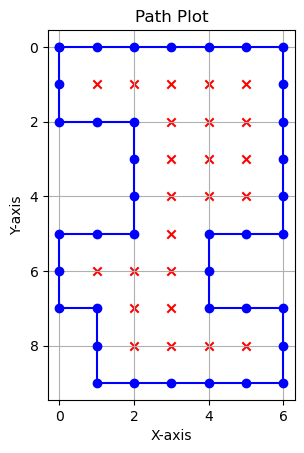

19:49:54.931:aoc2023 - INF: Tests passed!
19:49:55.039:aoc2023 - DBG: Processing 692 interior candidates.
19:49:55.045:aoc2023 - DBG: Updated exterior with 3191 points.
19:49:55.231:aoc2023 - DBG: Updated all_interior with 101645 points.
19:49:55.238:aoc2023 - DBG: Updated exterior with 2153 points.
19:49:55.248:aoc2023 - DBG: Updated exterior with 4665 points.
19:49:55.249:aoc2023 - DBG: Updated exterior with 47 points.
19:49:55.262:aoc2023 - DBG: Updated exterior with 6778 points.
19:49:55.268:aoc2023 - DBG: Updated exterior with 2824 points.
19:49:55.271:aoc2023 - DBG: Updated exterior with 1481 points.
19:49:55.275:aoc2023 - DBG: Updated exterior with 2103 points.
19:49:55.281:aoc2023 - DBG: Updated exterior with 2397 points.
19:49:55.285:aoc2023 - DBG: Updated exterior with 2047 points.
19:49:55.286:aoc2023 - DBG: Updated exterior with 105 points.
19:49:55.289:aoc2023 - DBG: Updated exterior with 1604 points.
19:49:55.292:aoc2023 - DBG: Updated exterior with 1009 points.
19:49:55.

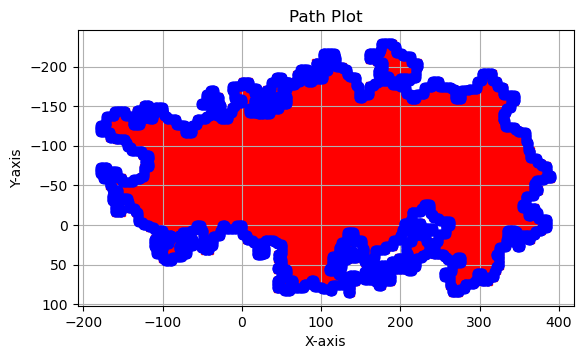

19:49:56.051:aoc2023 - INF: Part 1 soln=106459


CPU times: total: 516 ms
Wall time: 1.22 s


In [113]:
%%time
sample_inputs = []
sample_inputs.append("""R 6 (#70c710)
D 5 (#0dc571)
L 2 (#5713f0)
D 2 (#d2c081)
R 2 (#59c680)
D 2 (#411b91)
L 5 (#8ceee2)
U 2 (#caa173)
L 1 (#1b58a2)
U 2 (#caa171)
R 2 (#7807d2)
U 3 (#a77fa3)
L 2 (#015232)
U 2 (#7a21e3)""")
sample_answers = [62]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 18 Part 2

Uh oh. The colour and instruction parameters need to be swapped!! We need to extract the correct instructions from the hex codes.

For each hex code:

- First five digits = hex value of distance in m
- Last digit = direction, where `0 = R`, `1 = D`, `2 = L`, ` 3 = U`

**My solution:**

Even with the sample data, we're told that our lagoon will hold `952408144115` cubic metres of lava.  So clearly we have far too many points to go storing them in sets.  Our Part 1 solution isn't going to scale! We need to do something smarter.

We can use math!  Here are some key formulae:

- [Shoelace Formula](https://en.wikipedia.org/wiki/Shoelace_formula) - to calculate the area of any polygon, given the _consecutive coordinates_ of its vertices. One great thing about this formula is that it even works for self-overlapping / self-intersecting polygons!

$$
A = \frac{1}{2} \left| \sum_{i=1}^{n} x_i (y_{i+1} - y_{i-1}) \right|
$$

- [Pick's Theorem](https://en.wikipedia.org/wiki/Pick%27s_theorem) - to calculate the number of interior points for an enclosed polygon.

$$
A = i + \frac{b}{2} - 1
$$

However, our vertex coordinates are at the centre of 1x1 grid cells. Why? Because we start at the centre of a 1x1 cell, and then we dig the perimeter. So, from our sample input:

```text
#######
#######
#######
..#####
..#####
#######
#####..
#######
.######
.######
```

Let's use Matplotlib to draw a more accurate representation of the dig plan:

19:48:40.800:aoc2023 - DBG: Processing 10 interior candidates.
19:48:40.800:aoc2023 - DBG: Updated all_interior with 24 points.
19:48:40.801:aoc2023 - DBG: Updated exterior with 3 points.
19:48:40.801:aoc2023 - DBG: Updated exterior with 2 points.
19:48:40.802:aoc2023 - DBG: Updated exterior with 1 points.


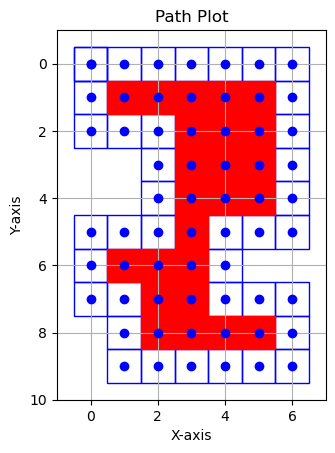

In [110]:
def plot_path(path: list[tuple], inside: set[tuple]=set()):
    fig, ax = plt.subplots()

    # Function to add a 1x1 square with the point at its center
    def add_square(x, y, colour, fill=False):
        square = Rectangle((x - 0.5, y - 0.5), 1, 1, fill=fill, edgecolor=colour, facecolor=colour)
        ax.add_patch(square)

    # Plot each point in the path as a square
    for point in path:
        add_square(point[0], point[1], 'blue')

    # Plot each point in the inside set as a square
    for point in inside:
        add_square(point[0], point[1], 'red', fill=True)

    # Extract x and y values for vertices
    path_x_values = [point[0] for point in path]
    path_y_values = [point[1] for point in path]
    inside_x_values = [point[0] for point in inside]
    inside_y_values = [point[1] for point in inside]
    
    # Plot the actual vertex points
    ax.scatter(path_x_values, path_y_values, color="blue", zorder=5)
    ax.scatter(inside_x_values, inside_y_values, color="blue", zorder=5)
    
    # Set limits for x and y axis
    all_x_values = [point[0] for point in path] + [point[0] for point in inside]
    all_y_values = [point[1] for point in path] + [point[1] for point in inside]

    ax.set_xlim(min(all_x_values) - 1, max(all_x_values) + 1)
    ax.set_ylim(min(all_y_values) - 1, max(all_y_values) + 1)

    plt.title('Path Plot')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

plan = parse_plan(sample_inputs[0].splitlines())
perimeter_path, interior_candidates = process_plan(plan)
perimeter_set = set(perimeter_path)

bounds = get_bounds(perimeter_path)
all_interior = flood_fill(perimeter_set, interior_candidates, bounds)
plot_path(perimeter_path, all_interior)

So it looks like this:

![Dig plan](https://aoc.just2good.co.uk/assets/images/lava_lagoon_1-by-1_squares.png)

Our vertex coordinates represent the top left of each cell. But in order to use the _Shoelace Formula_, we need our vertices to be on the _outside_ of each corner. We could adjust our vertices to achieve this.

Or alternatively, we can combine the _Shoelace formula_ with _Pick's Theorem_ to determine the number of _internal coordinates bounded by our polygon_. This is what we need! I.e.

1. Determine the area of the _overall_ polygon, using _Shoelace_.
2. Determine the number of perimeter boundary points, which is also the perimeter volume. (Since our perimeter is made up of 1x1 squares.)
3. Rearrange _Pick's Theorem_ to make use of this area and the number of boundary points, to determine the number of _internal integer coordinates_, i.e.

$$
\begin{align}
A &= i + \frac{b}{2} - 1 \\
\\
i &= A - \frac{b}{2} + 1
\end{align}
$$

4. Add the perimeter volume to the number of internal integer coordinates, to get the overall polygon volume.

In [97]:
def parse_plan_hex(data) -> list[tuple]:
    """ 
    Parse input data and convert into a list of instructions like this:
    [('R', 461937), ('D', 56407), ...]
    """
    dirs = { 0: "R", 1: "D", 2: "L", 3: "U" }
    
    plan:list[tuple] = []
    for line in data:
        instr = line[-7:-1]
        dirn = dirs[int(instr[-1])]
        path_len = int(instr[0:-1], base=16)
        plan.append((dirn, int(path_len)))
        
    return plan

def process_turns(plan) -> list[tuple[int,int]]:
    """ 
    Process the plan instructions, and return the perimeter path, which contains only the vertices of the polygon. E.g.
    [(0, 0), (461937, 0), (461937, 56407), (818608, 56407), ...]
    """
    # initialise, from current
    current = (0,0)
    path:list[tuple[int,int]] = [current]

    for dirn_char, path_len in plan:
        dirn = VectorDicts.DIRS[dirn_char]
        current = (current[0]+dirn[0]*path_len, current[1]+dirn[1]*path_len)
        path.append(current)

    return path

def shoelace_area(polygon: list[tuple[int,int]]) -> int:
    total = 0
    for i, (x,y) in enumerate(polygon):
        next_index = (i+1) % len(polygon)
        prev_index = i-1
        total += x*(polygon[next_index][1] - polygon[prev_index][1])
        
    return abs(total) // 2

def interior_points(area: int, boundary_points: int):
    return area - (boundary_points // 2) + 1

def perimeter_length(polygon: list[tuple[int,int]]) -> int:
    """ The total length of all the edges of this polygon. This is equivalent to the number of boundary points. """
    total = 0
    for i, (x,y) in enumerate(polygon):
        next_index = (i+1) % len(polygon)
        total += abs(polygon[next_index][0]-x) + abs(polygon[next_index][1]-y) # there will only ever be an x or y component
        
    return total

def total_area(plan: list) -> int:
    """ Return total area of the polygon, including the perimeter.
    Combine Shoelace formula and Pick's theorem to determine internal integer points of the polygon.
    Then add the total number of points that make up the perimeter.

    Args:
        plan (_type_): _description_

    Returns:
        int: _description_
    """
    perimeter_path = process_turns(plan)
    polygon_area = shoelace_area(perimeter_path)
    boundary_points = perimeter_length(perimeter_path)
    interior_area = interior_points(polygon_area, boundary_points)
    return interior_area + boundary_points    


In [95]:
def solve(data) -> int:
    plan = parse_plan(data)
    area = total_area(plan)
    logger.debug(f"Part 1: {area=}")

    plan = parse_plan_hex(data)
    area = total_area(plan)
    logger.debug(f"Part 2: {area=}")    
    
    return area
 

In [96]:
%%time
sample_answers = [952408144115]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input.splitlines()), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve(input_data)
logger.info(f"Part 2 soln={soln}")

19:25:36.691:aoc2023 - DBG: Part 1: area=62
19:25:36.692:aoc2023 - DBG: Part 2: area=952408144115
19:25:36.692:aoc2023 - INF: Tests passed!
19:25:36.693:aoc2023 - DBG: Part 1: area=106459
19:25:36.695:aoc2023 - DBG: Part 2: area=63806916814808
19:25:36.695:aoc2023 - INF: Part 2 soln=63806916814808


CPU times: total: 0 ns
Wall time: 5 ms


---
## Day 19: Aplenty

In [ ]:
DAY = "19" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 19 Part 1

The parts are being organised...

- x: Extremely cool looking
- m: Musical (it makes a noise when you hit it)
- a: Aerodynamic
- s: Shiny

Then the parts are sent through a series of named workflows. Each workflow has a list of rules which determine where the part goes, based on the first condition that is true.

Sample input:

```text
px{a<2006:qkq,m>2090:A,rfg}
pv{a>1716:R,A}
lnx{m>1548:A,A}
rfg{s<537:gd,x>2440:R,A}
qs{s>3448:A,lnx}
qkq{x<1416:A,crn}
crn{x>2662:A,R}
in{s<1351:px,qqz}
qqz{s>2770:qs,m<1801:hdj,R}
gd{a>3333:R,R}
hdj{m>838:A,pv}

{x=787,m=2655,a=1222,s=2876}
{x=1679,m=44,a=2067,s=496}
{x=2036,m=264,a=79,s=2244}
{x=2461,m=1339,a=466,s=291}
{x=2127,m=1623,a=2188,s=1013}
```

Here we have a list of workflows, then a list of part ratings. Parts always start with workflow `in`.

- `A` = Accepted
- `R` = Rejected

**Sort through all of the parts you've been given; what do you get if you add together all of the rating numbers for all of the parts that ultimately get accepted?**

In [ ]:
@dataclass
class Workflow():
    """ 
    A Workflow is a list of rules that we must apply to a part. 
    Each rule maps a condition to another workflow.
    Rules are executed in order.  
    We determine the next available workflow based on the first rule that evaluates to True.
    """
    name: str # e.g. "in", "qqz"
    
    # [ {condition: next_flow }, ...]
    # For any given condition (if not True or False), the first operand is a part category, 
    # and the second operand is an int value
    rules: list[tuple[str, str]] 
    
    ops = {
        ">": operator.gt,
        "<": operator.lt,
    }

    @staticmethod
    def parse_condition(condition):
        """ Returns left_operand, operator, right_operand for a given condition """
        op = next(op for op in Workflow.ops if op in condition)
        left_operand, right_operand = condition.split(op)
        return left_operand, op, int(right_operand)
    
    def execute(self, part: dict):
        """ Execute rules in order, for this part. Return the matching next workflow. """
        for condition, next_flow in self.rules:
            if condition[0] in "xmas":
                left, op, right = self.parse_condition(condition)
                part_val = part[left]
                res = Workflow.ops[op](part_val, right)
            else:
                res = True
            
            if res:
                return next_flow
        
        assert False, "At least one condition must be True"

In [ ]:
def parse_input(data: str) -> tuple[dict[str,Workflow], list[dict[str,int]]]:
    """ The input contains two blocks: workflows, and parts.
    Parse the workflows into a dict of Workflow objects.
    Parse the parts into a list of part dictionaries. """
    flow_lines, part_lines = [block.splitlines() for block in data.split("\n\n")]
    
    workflows = {}
    for flow_line in flow_lines:
        flow_name, flow_rules = flow_line.split("{")
        flow_rules = flow_rules.strip("}") # remove trailing }
        flow_rules = [flow_rule for flow_rule in flow_rules.split(",")]
        
        new_rules = [] # Dua protocol
        for rule in flow_rules:
            if ":" in rule:
                new_rules.append(tuple(rule.split(":")))
            else:  # final condition is always true
                new_rules.append(("True", rule))
                
        workflows[flow_name] = Workflow(flow_name, new_rules)
    
    parts = []
    for part_line in part_lines:
        part_line = part_line[1:-1] # strip off the leading and trailing brackets
        components = part_line.split(",")
        cat_vals = {}
        for component in components:
            cat, cat_val = component.split("=")
            cat_vals[cat] = int(cat_val)
        
        parts.append(cat_vals)
        
    return workflows, parts

In [ ]:
def solve_part1(data):
    workflows, parts = parse_input(data)
    
    accepted:list[dict[str, int]] = []
    for part in parts: 
        current_flow = workflows["in"]
        while True:
            workflow_out = current_flow.execute(part)
            if workflow_out in ("A", "R"):
                if workflow_out == "A":
                    accepted.append(part)
                break
            
            current_flow = workflows[workflow_out]
            
    return sum(sum(part.values()) for part in accepted)


In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""px{a<2006:qkq,m>2090:A,rfg}
pv{a>1716:R,A}
lnx{m>1548:A,A}
rfg{s<537:gd,x>2440:R,A}
qs{s>3448:A,lnx}
qkq{x<1416:A,crn}
crn{x>2662:A,R}
in{s<1351:px,qqz}
qqz{s>2770:qs,m<1801:hdj,R}
gd{a>3333:R,R}
hdj{m>838:A,pv}

{x=787,m=2655,a=1222,s=2876}
{x=1679,m=44,a=2067,s=496}
{x=2036,m=264,a=79,s=2244}
{x=2461,m=1339,a=466,s=291}
{x=2127,m=1623,a=2188,s=1013}""")

sample_answers = [19114]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 19 Part 2

Rather than push parts through the workflows, we need to determine which combinations of category ratings will be accepted or rejected.

Each category rating can have an int value from 1 to 4000 (inclusive).

**Consider only your list of workflows; the list of part ratings that the Elves wanted you to sort is no longer relevant. How many distinct combinations of ratings will be accepted by the Elves' workflows?**

**My solution:**

- Start with "in".
- Recurse through all conditions, and determine which would result in "R".
- Where they do, exclude the conditions that led to this R.
- Let's build up a list of all the conditions that result in R.

In [ ]:
def count_ranges(ranges:dict[str, tuple[int,int]], workflow_name: str, workflows: dict[str, Workflow]) -> int:
    """ Count total number of distinct accepted part ratings numbers.

    Args:
        ranges (dict[str, tuple[int,int]]): Range for a given category, as (low, high) inclusive.
        workflow_name (str): Name of a workflow.
        workflows (dict[str, Workflow]): dictionary of all our workflows, keyed by name
    """
    logger.debug(f"{workflow_name=}")
        
    # Base case
    if workflow_name == "R": # rejected count
        return 0
    
    if workflow_name == "A": # accepted count
        # product of all the ranges
        logger.debug(f"Accepted {ranges=}")
        return math.prod((high-low+1) for low, high in ranges.values())
            
    workflow = workflows[workflow_name]
    total = 0
    for condition, next_flow in workflow.rules: # process rules for this workflow
        if condition[0] in "xmas": # We need to split the range into two segments
            cat, op, right_val = Workflow.parse_condition(condition) # e.g. a, <, 2006
            low, high = ranges[cat] # current inclusive range for this category
            
            # split the current range based on this this condition
            # E.g. with current range 1,4000:
            #      a<1716 means split into 1-1715 (true), 1716-4000 (false)
            #      a>1716 means split into 1-1716 (false), 1717-4000 (true)
            
            # True for condition: we're done with this workflow, so recurse to the next
            true_for_condition = (low, right_val - 1) if op == "<" else (right_val + 1, high)
            
            # False for condition: we need to try the next rule in this workflow
            false_for_condition = (right_val, high) if op == "<" else (low, right_val)
            
            # Check if the condition splits are NOT empty
            # First, check if true component non-empty. 
            # These will need to be processed by subseqauent rules.
            if true_for_condition[0] <= true_for_condition[1]: 
                # for any True in this range, we're done with this workflow, so recurse to next workflow
                ranges_copy = dict(ranges) # make a copy of ranges
                ranges_copy[cat] = true_for_condition # pass through the new, true range
                total += count_ranges(ranges_copy, next_flow, workflows) 
            
            if false_for_condition[0] <= false_for_condition[1]: # false half non-empty
                # for any False in this range, we need to move to the next rule in THIS workflow
                ranges = dict(ranges) 
                ranges[cat] = false_for_condition # pass through the new, false range
            else: # false half is empty, so nothing left to do in this workflow
                break
        else: # we're at the "True" rule in our workflow
            assert condition == "True", "We must be at the final condition."
            total += count_ranges(ranges, next_flow, workflows) # recurse to next workflow
            
    return total

In [ ]:
def solve_part2(data):
    workflows, _ = parse_input(data)
    
    ranges = { cat: (1, 4000) for cat in "xmas" }
    logger.debug(ranges)
    accepted = count_ranges(ranges, workflow_name="in", workflows=workflows)
    
    return accepted

In [ ]:
%%time
sample_answers = [167409079868000]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 20: Pulse Propagation

In [ ]:
DAY = "20" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 20 Part 1

Modules communicate using pulses.  

- There are two types of pulses: `high` and `low`. 
- For any given module, each pulse is sent to a list of destination modules. 
- _Flip-flop_ modules (prefix `%`) are either on or off.  
  - They are initially off. 
  - If it receives a `low` pulse it flips. When it flips on, it sends a `high` pulse. When it flips off, it sends a `low` pulse.
  - If it receives a `high`, it does nothing.
- _Conjunction_ modules (prefix `&`) remember the type of pulse received from each of its inputs. They initially default to remembering `low` pulse. When it receives a pulse, it updates its memory state, and then:
  - If all inputs remembered are `high`, it sends a `low`.
  - Otherwise it sends a `high`.
- There is one _broadcast_ module. When it receives a pulse, it sends the same pulse to all of its destinations.
- There is a _button_ module. When pressed, it sends `low` to _broadcast_.
- Modules are processed in the order they are sent. (So, breadth first, rather than depth first.)

Sample configuration:

```text
broadcaster -> a, b, c
%a -> b
%b -> c
%c -> inv
&inv -> a
```

**Consult your module configuration; determine the number of low pulses and high pulses that would be sent after pushing the button 1000 times, waiting for all pulses to be fully handled after each push of the button. What do you get if you multiply the total number of low pulses sent by the total number of high pulses sent?**



In [ ]:
@dataclass
class Module(abc.ABC):
    id: str
    inputs: list[Module] = field(default_factory=list)
    outputs: list[Module] = field(default_factory=list)
    low_sent: int = 0
    high_sent: int = 0

    def add_input(self, module: Module):
        self.inputs.append(module)

    def add_output(self, module: Module):
        self.outputs.append(module)

    def _send_pulse(self, pulse: int):
        # logger.debug(f"{self.id} -> {pulse} -> {[mod.id for mod in self.outputs]}")
        for mod in self.outputs:
            if pulse == 0:
                self.low_sent += 1
            else:
                self.high_sent += 1
            mod.pulse_received(self, pulse)

    @abc.abstractmethod
    def send_pulse(self):
        pass

    @abc.abstractmethod
    def pulse_received(self, in_module: Module, pulse: int):
        pass

    def __str__(self) -> str:
        input_ids = [input_module.id for input_module in self.inputs]
        output_ids = [output_module.id for output_module in self.outputs]
        return f"Module(id={self.id}, inputs={input_ids}, outputs={output_ids})"

class FlipFlop(Module):
    state:bool = False # initially off

    def send_pulse(self):
        pulse = 1 if self.state else 0
        self._send_pulse(pulse)

    def pulse_received(self, in_module: Module, pulse: int):
        if pulse == 0:
            self.state = not self.state
            self.send_pulse()
    
    def __str__(self):
        return f"{super().__str__()}, state={self.state}"

class Conjunction(Module):
    state: dict[str, int] = {}

    def add_input(self, module: Module):
        super().add_input(module)
        self.state[module.id] = 0

    def pulse_received(self, in_module: Module, pulse: int):
        self.state[in_module.id] = pulse
        self.send_pulse()

    def send_pulse(self):
        input_mod_ids = [input_mod.id for input_mod in self.inputs]
        pulse = 0 if all(self.state[id] for id in input_mod_ids) else 1
        self._send_pulse(pulse)

    def __str__(self):
        return f"{super().__str__()}, state={self.state}"

class Broadcaster(Module):
    received:int

    def pulse_received(self, in_module: Module, pulse: int):
        self.received = pulse
        self.send_pulse()
    
    def send_pulse(self):
        self._send_pulse(self.received)

class Button(Module):
    def send_pulse(self):
        self._send_pulse(0) # always sends 0 to broadcast

    def pulse_received(self, in_module: Module, pulse: int):
        pass

    def push(self):
        self.send_pulse()
  
class Output(Module):
    received:int

    def send_pulse(self):
        pass

    def pulse_received(self, in_module: Module, pulse: int):
        self.received = pulse

In [ ]:
def parse_modules(data: list[str]) -> dict[str, Module]:
    modules:dict[str, Module] = {}

    # create the modules
    for line in data:
        mod_part, outputs_part = line.split(" -> ")
        if mod_part[0] == "%":
            modules[mod_part[1:]] = FlipFlop(mod_part[1:])
        elif mod_part[0] == "&":
            modules[mod_part[1:]] = Conjunction(mod_part[1:])
        else:
            assert mod_part == "broadcaster", "This must be a broadcaster module"
            modules[mod_part] = Broadcaster(mod_part)

    # now register inputs and outputs
    for line in data:
        mod_part, outputs_part = line.split(" -> ")
        if mod_part == "broadcaster":
            module = modules[mod_part]
        else:
            module = modules[mod_part[1:]]

        output_names = [name.strip() for name in outputs_part.split(",")]

        # check for outputs that aren't inputs
        for output_name in output_names:
            if output_name not in modules:
                modules[output_name] = Output(output_name)

            module.add_output(modules[output_name])
            modules[output_name].add_input(module)
            
    return modules

In [ ]:
def solve_part1(modules: list[Module]):
    button = Button("button")
    modules[button.id] = button
    button.add_output(modules["broadcaster"])
    for _ in range(1000):
        button.push()

    low_sent = sum(module.low_sent for module in modules.values())
    high_sent = sum(module.high_sent for module in modules.values())
    logger.debug(f"{low_sent=}, {high_sent=}")
    prod = low_sent*high_sent
    logger.debug(f"{prod=}")
    return prod


In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""broadcaster -> a, b, c
%a -> b
%b -> c
%c -> inv
&inv -> a""")

sample_inputs.append("""broadcaster -> a
%a -> inv, con
&inv -> b
%b -> con
&con -> output""")

sample_answers = [32000000, 11687500]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_modules = parse_modules(curr_input.splitlines())
    validate(solve_part1(curr_modules), curr_ans) # test with sample data

logger.info("Tests passed!")

modules = parse_modules(input_data)
soln = solve_part1(modules)
logger.info(f"Part 1 soln={soln}")

### Day 20 Part 2

In Part 1, it transpired that _rx_ was only an output.

In Part 2, we're told that _rx_ turns on when a single low pulse is sent to rx.

**Reset all modules to their default states. Waiting for all pulses to be fully handled after each button press, what is the fewest number of button presses required to deliver a single low pulse to the module named rx?**

First, I'll try brute force.  I'll just push the button until a low pulse arrives at _rx_.

Conclusion: this takes 30s to execute 1m button presses, and still doesn't exit.  So, the number could be huge, and this solution probably isn't viable. I need to be smarter!

In [ ]:
def solve_part2(modules: list[Module]):
    button = Button("button")
    modules[button.id] = button
    button.add_output(modules["broadcaster"])
    rx: Output = modules["rx"]
    button_presses = 0
    while True:
        button.push()
        button_presses += 1
        if rx.received == 0:
            break

        if button_presses == 100000:
            assert False, "This is going to take a while"

    return button_presses
    

In [ ]:
%%time
modules = parse_modules(input_data) # reset modules states
soln = solve_part2(modules)
logger.info(f"Part 2 soln={soln}")

---
## Day n: title

In [ ]:
DAY = "n" # replace with actual number (without leading digit)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day n Part 1

Overview...

In [ ]:
def solve(data):
    pass

In [ ]:
%%time
sample_inputs = ["abcdef"]
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day n Part 2

Overview...

In [ ]:
def solve_part2(data):
    pass

In [ ]:
%%time
sample_inputs = ["abcdef"]
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")